In [ ]:
!pip install -U tensorflow-gpu keras tensorflow-hub tf-nightly==2.4.0.dev20200812

  Using cached https://files.pythonhosted.org/packages/1d/a2/5ccf0a418eb22e0a2ae9edc1e7f5456d0a4b8b49524572897564b4030a9b/tensorflow_gpu-2.5.0-cp37-cp37m-manylinux2010_x86_64.whl
Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)
Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.7/dist-packages (0.12.0)
ERROR: Could not find a version that satisfies the requirement tf-nightly==2.4.0.dev20200812 (from versions: 2.6.0.dev20210501, 2.6.0.dev20210502, 2.6.0.dev20210503, 2.6.0.dev20210504, 2.6.0.dev20210505, 2.6.0.dev20210506, 2.6.0.dev20210507, 2.6.0.dev20210508, 2.6.0.dev20210509, 2.6.0.dev20210510, 2.6.0.dev20210511, 2.6.0.dev20210512, 2.6.0.dev20210513, 2.6.0.dev20210514, 2.6.0.dev20210516, 2.6.0.dev20210517, 2.6.0.dev20210518, 2.6.0.dev20210519, 2.6.0.dev20210520, 2.6.0.dev20210521, 2.6.0.dev20210522, 2.6.0.dev20210523, 2.6.0.dev20210524, 2.6.0.dev20210525, 2.6.0.dev20210526, 2.6.0.dev20210527, 2.6.0.dev20210528, 2.6.0.dev2021

In [ ]:
!git clone https://github.com/woolia/j_image.git

Cloning into 'j_image'...
remote: Enumerating objects: 63679, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 63679 (delta 0), reused 6 (delta 0), pack-reused 63673
Receiving objects: 100% (63679/63679), 616.61 MiB | 37.75 MiB/s, done.
Checking out files: 100% (83205/83205), done.


In [ ]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import skimage.io as io
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import zipfile

base_dir = '/content/drive/MyDrive/모델링완성작/응가/progan2'

In [ ]:
tf.autograph.set_verbosity(0)

In [ ]:
def n_filters(stage, fmap_base, fmap_max, fmap_decay):
  """Get the number of filters in a convolutional layer."""
  return int(min(fmap_max, fmap_base / 2.0 ** (stage * fmap_decay)))


def pixelwise_feature_norm(x, epsilon=1e-8):
  """Pixelwise feature normalization for the output of convolutional layers."""
  return x / K.sqrt(
      K.mean(K.square(x), axis=len(x.shape)-1, keepdims=True) + epsilon)


def layer_init_stddev(shape, gain=np.sqrt(2)):
  """Get the He initialization scaling term."""
  fan_in = np.prod(shape[:-1])
  return gain / np.sqrt(fan_in)


def Dense(x, units,
          use_wscale=False,
          gain=np.sqrt(2),
          name=None):
  """Build a densely connected layer."""
  if len(x.shape) > 2:
    x = K.reshape(x, shape=(-1, np.prod(x.shape[1:])))
  stddev = layer_init_stddev([x.shape[1], units], gain=gain)
  if use_wscale:
    weight_init = tf.keras.initializers.RandomNormal()
    x = tf.keras.layers.Dense(units, activation=None,
                              kernel_initializer=weight_init,
                              use_bias=False,
                              name=name)(x)
    x = tf.keras.layers.Lambda(
        lambda x: x * K.constant(stddev, dtype='float32'))(x)
    return x
  weight_init = tf.keras.initializers.RandomNormal(0.0, stddev)
  return tf.keras.layers.Dense(units, activation=None,
                               kernel_initializer=weight_init,
                               use_bias=False,
                               name=name)(x)


class Bias(tf.keras.layers.Layer):
  """Bias layer for applying the bias after weight scaling."""
  def __init__(self, shape, *args, **kwargs):
    super(Bias, self).__init__(*args, **kwargs)
    self.shape = shape
    self._config = {'shape': shape}
    self.b = self.add_weight('bias',
                             shape=shape,
                             initializer='zeros',
                             trainable=True)

  def call(self, x):
    """Call method for functional API."""
    return x + self.b


def Conv2D(x, filters, kernel,
           gain=np.sqrt(2),
           use_wscale=False,
           name=None,
           **unused_kwargs):
  """Build a 2D convolutional layer."""
  stddev = layer_init_stddev([kernel, kernel, x.shape[1], filters], gain=gain)
  if use_wscale:
    weight_init = tf.keras.initializers.RandomNormal()
    x = tf.keras.layers.Conv2D(filters, kernel,
                               strides=(1, 1),
                               padding='same',
                               kernel_initializer=weight_init,
                               use_bias=False,
                               activation=None,
                               name=name)(x)
    x = tf.keras.layers.Lambda(
        lambda x: x * K.constant(stddev, dtype='float32'))(x)
    return x
  weight_init = tf.keras.initializers.RandomNormal(0.0, stddev)
  return tf.keras.layers.Conv2D(filters, kernel,
                                strides=(1, 1),
                                padding='same',
                                kernel_initializer=weight_init,
                                use_bias=False,
                                activation=None,
                                name=name)(x)



class Lerp(tf.keras.layers.Layer):
  """A linear interpolation layer for fading in higher resolutions."""

  def __init__(self, t, *args, **kwargs):
    super(Lerp, self).__init__(*args, **kwargs)
    self.t = t

  def call(self, a, b, *args, **kwargs):
    """Call method for functional API."""
    return a + (b - a) * self.t


def resolution_label(res_log2):
  """Create an image resolution label."""
  return '{}x{}'.format(1 << res_log2, 1 << res_log2)

In [ ]:
def G(latent_size=None,  # Dimensionality of latent space.
      fmap_base=8192,
      fmap_max=512,  # Max filters in each conv layer.
      fmap_decay=1.0,
      normalize_latents=True,  # Pixelwise normalize latent vector.
      use_wscale=True,  # Scale the weights with He init at runtime.
      use_pixel_norm=True,  # Use pixelwise normalization.
      use_leaky_relu=True,  # True = use LeakyReLU, False = use ReLU.
      num_channels=3,  # Number of output channels.
      resolution=64,  # Resolution of the output.
      **unused_kwargs):
  """Build the generator networks for each size."""
  if latent_size is None:
    latent_size = min(fmap_base, fmap_max)

  partial_nfilters = lambda n: n_filters(n, fmap_base, fmap_max, fmap_decay)

  opts = {
      'use_wscale': use_wscale,
      'use_pixel_norm': use_pixel_norm,
      'use_leaky_relu': use_leaky_relu,
  }

  # We can set the value of this during training with a callback.
  alpha = K.variable(0.0, dtype='float32', name='alpha')

  models = {}
  resolution_log2 = int(np.log2(resolution))

  for max_res_log2 in range(2, resolution_log2 + 1):
    latents_in = tf.keras.layers.Input(shape=(latent_size,), name='latents_in')
    x = latents_in
    if normalize_latents:
      x = pixelwise_feature_norm(x)
    x = G_block(x, 2, partial_nfilters, **opts)
    img = toRGB(x, num_channels, **opts, name='4x4_to_rgb')

    if max_res_log2 == 2:
      models['4x4'] = tf.keras.models.Model(latents_in, img)
      continue

    img_prev = img

    for res_log2 in range(3, max_res_log2 + 1):
      x = G_block(x, res_log2, partial_nfilters, **opts)
      if res_log2 == (max_res_log2 - 1):
        img_prev = toRGB(x, num_channels, **opts,
                         name='{}_to_rgb'.format(resolution_label(res_log2)))
      if res_log2 == max_res_log2:
        img = toRGB(x, num_channels, **opts,
                    name='{}_to_rgb'.format(resolution_label(res_log2)))
        img = Lerp(alpha)(tf.keras.layers.UpSampling2D()(img_prev), img)

    label = resolution_label(max_res_log2)
    models[label] = tf.keras.models.Model(latents_in, [img, img_prev])

  return models, alpha


def G_block(x, res_log2, n_filters,
            use_pixel_norm=False,
            use_wscale=False,
            use_leaky_relu=False,
            **unused_kwargs):
  """Build a block of the generator."""
  pn = lambda x: pixelwise_feature_norm(x) if use_pixel_norm else x
  act = (tf.keras.layers.LeakyReLU() if use_leaky_relu
         else tf.keras.layers.Activation('relu'))
  
  nf = n_filters(res_log2 - 1)

  if res_log2 == 2:
    # Start with dense layer.
    units = nf << 4
    x = Dense(x, units, gain=np.sqrt(2)/4, use_wscale=use_wscale,
              name='G_dense_head')
    x = K.reshape(x, [-1, 4, 4, nf])
    x = Bias([1, 1, nf], name='G_dense_head_bias')(x)
    x = pn(act(x))
    # Then the first convolutional layer.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale, name='4x4_conv')
    x = Bias([1, 1, nf], name='4x4_conv_bias')(x)
    return pn(act(x))
  else:
    res_label = resolution_label(res_log2)
    # Upsample the input.
    x = tf.keras.layers.UpSampling2D()(x)

    # Now 2 convolutional layers.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv0'.format(res_label))
    x = Bias([1, 1, nf], name='{}_conv0_bias'.format(res_label))(x)
    x = pn(act(x))

    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv1'.format(res_label))
    x = Bias([1, 1, nf], name='{}_conv1_bias'.format(res_label))(x)
    return pn(act(x))
  return x


def toRGB(x, channels,
          use_pixel_norm=False,
          use_wscale=False,
          use_leaky_relu=False,
          name=None,
          **unused_kwargs):
  """Convert a 4D tensor into the RGB color space."""
  pn = lambda x: pixelwise_feature_norm(x) if use_pixel_norm else x
  act = (tf.keras.layers.LeakyReLU() if use_leaky_relu
         else tf.keras.layers.Activation('relu'))
  x = Conv2D(x, filters=channels, kernel=1, gain=1, use_wscale=use_wscale,
             name=name)
  bias_name = None if name is None else name + '_bias'
  x = Bias([1, 1, channels], name=bias_name)(x)
  return tf.keras.layers.Activation('sigmoid')(x)

In [ ]:
def D(num_channels=3,  # Number of channels images have.
      resolution=64,  # Max image resolution.
      fmap_base=8192,
      fmap_max=512,  # Max filters in each conv layer.
      fmap_decay=1.0,
      use_wscale=True,  # Scale the weights with He init at runtime.
      mbstd_group_size=4, # Group size for minibatch stddev layer.
      **unused_kwargs):
  """Build the discriminator networks for each size."""
  partial_nfilters = lambda n: n_filters(n, fmap_base, fmap_max, fmap_decay)
  resolution_log2 = int(np.log2(resolution))
  opts = {
      'use_wscale': use_wscale,
      'mbstd_group_size': mbstd_group_size,
  }

  # We can set the value of this during training with a callback.
  alpha = K.variable(0.0, dtype='float32', name='alpha')
  img_ins = {
      resolution_label(res_log2): tf.keras.layers.Input(
          shape=(1 << res_log2, 1 << res_log2, num_channels))
      for res_log2 in range(2, resolution_log2 + 1)
  }
  outputs = {}

  for max_res_log2 in range(2, resolution_log2 + 1):
    label = resolution_label(max_res_log2)
    x = img_ins[label]
    x = fromRGB(x, filters=partial_nfilters(max_res_log2 - 1),
                name='{}_from_rgb'.format(label), **opts)
    for res_log2 in range(max_res_log2, 2, -1):
      x = D_block(x, res_log2, partial_nfilters, **opts)
      if res_log2 == max_res_log2:
        prev_label = resolution_label(res_log2 - 1)
        prev_img = img_ins[prev_label]
        y = fromRGB(prev_img, partial_nfilters(res_log2 - 2),
                    name='{}_from_rgb'.format(prev_label), **opts)
        x = Lerp(alpha)(y, x)
    outputs[label] = D_block(x, 2, partial_nfilters, **opts)

  models = {}
  for res_log2 in range(2, resolution_log2 + 1):
    label = resolution_label(res_log2)
    ins = [img_ins[label]]
    if res_log2 > 2:
      ins.append(img_ins[resolution_label(res_log2 - 1)])
    models[label] = tf.keras.models.Model(ins, outputs[label])
  
  return models, alpha


def fromRGB(x, filters,
            use_wscale=False,
            name=None,
            **unused_kwargs):
  """First covolutional layer after an RGB layer."""
  x = Conv2D(x, filters=filters, kernel=1, use_wscale=use_wscale, name=name)
  bias_name = None if name is None else name + '_bias'
  x = Bias([1, 1, filters], name=bias_name)(x)
  return tf.keras.layers.LeakyReLU()(x)


def D_block(x, res_log2, n_filters,
            mbstd_group_size=4,
            use_wscale=False,
            **unused_kwargs):
  """Build a block of the discriminator conv net."""
  act = tf.keras.layers.LeakyReLU()
  nf = n_filters(res_log2 - 1)
  if res_log2 == 2:
    # Apply minibatch stddev layer.
    x = MinibatchStddev(x, mbstd_group_size)

    # Then a convolutional layer.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale, name='4x4_conv')
    x = Bias([1, 1, nf], name='4x4_conv_bias')(x)
    x = act(x)

    # Now we add the dense head to the discriminator.
    nf = n_filters(0)
    x = tf.keras.layers.Flatten(data_format='channels_last')(x)
    x = Dense(x, nf, use_wscale=use_wscale, name='D_dense_head')
    x = Bias([nf], name='D_dense_head_bias')(x)
    x = act(x)
    x = Dense(x, 1, gain=1, use_wscale=use_wscale, name='D_logit')
    x = Bias([1], name='D_logit_bias')(x)
  else:
    label = resolution_label(res_log2)

    # First convolutional layer.
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv0'.format(label))
    x = Bias([1, 1, nf], name='{}_conv0_bias'.format(label))(x)
    x = act(x)

    # Second convolutional layer.
    nf = n_filters(res_log2 - 2)
    x = Conv2D(x, filters=nf, kernel=3, use_wscale=use_wscale,
               name='{}_conv1'.format(label))
    x = Bias([1, 1, nf], name='{}_conv1_bias'.format(label))(x)
    x = act(x)
    
    # And downscale.
    x = Downscale2D(x)
  return x


def MinibatchStddev(x, group_size):
  """Contatenate the stddev of the minibatch to the output of a conv layer."""
  y = K.reshape(x, [group_size, -1, *x.shape[1:]])
  y = K.cast(y, 'float32')
  y -= K.mean(y, axis=0, keepdims=True)
  y = K.mean(K.square(y), axis=0)
  y = K.cast(y, x.dtype)
  y = K.tile(y, [group_size, 1, 1, 1])
  return K.concatenate([x, y], axis=1)


def Downscale2D(x):
  """Downscale layer scales an image down 2x."""
  return tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='valid',
                                          data_format='channels_last')(x)

In [ ]:
class WGANGP(tf.keras.models.Model):
  """
  A single WGAN-GP network.

  This implements the training objective for a single resolution
  of ProGAN. This model is applied iteratively over each resolution
  with a fresh optimizer. The motivation of ProGAN is to treat each
  resolution as an entirely different learning task, and uses the
  pretrained lower layers for transfer learning.

  In order to properly implement the gradient penalty loss term
  with TensorFlow 2.x, we need to extend the Keras model with
  our own custom training method. Since we have to use this model
  extension, we can also encapsulate the "fading in" the next
  resolutions.
  
  """

  def __init__(self,
               resolution,
               G,
               D,
               G_optimizer,
               D_optimizer,
               batch_size,
               latent_size,
               G_alpha=None,
               D_alpha=None,
               gradient_weight=10.0,
               D_repeat=1,
               *args, **kwargs):
    super(WGANGP, self).__init__(*args, **kwargs)
    self.resolution = resolution
    self.G = G
    self.D = D
    self.G_optimizer = G_optimizer
    self.D_optimizer = D_optimizer
    self.batch_size = batch_size
    self.latent_size = latent_size
    self.gradient_weight = gradient_weight

    self.G_alpha = G_alpha
    self.D_alpha = D_alpha

    self.D_repeat = D_repeat

  def compute_D_loss(self, real_imgs):
    """Compute discriminator loss terms."""

    # Generate the image at lower resolution for layer fading.
    latents_in = np.random.normal(size=(self.batch_size, self.latent_size))
    if self.resolution > 4:
      fake_imgs = self.G(latents_in)
      interp_imgs = [self.interpolate_imgs(real_imgs[i], fake_imgs[i])
                     for i in range(2)]
    else:
      fake_imgs = [self.G(latents_in)]
      interp_imgs = [self.interpolate_imgs(real_imgs[0], fake_imgs[0])]
    
    real_pred = self.D(real_imgs)
    fake_pred = self.D(fake_imgs)

    real_loss = tf.reduce_mean(real_pred)
    fake_loss = -tf.reduce_mean(fake_pred)
    gp_loss = self.gradient_penalty(interp_imgs)

    return real_loss, fake_loss, gp_loss

  def interpolate_imgs(self, real_img, fake_img):
    """Interpolate real and fake images for GP loss calculation."""
    w = tf.random.uniform([self.batch_size, 1, 1, 1], 0.0, 1.0)
    return (w * real_img) + ((1.0 - w) * fake_img)

  def gradient_penalty(self, interp_imgs):
    """Compute gradient penalty loss."""
    with tf.GradientTape() as tape:
      tape.watch(interp_imgs)
      interp_pred = self.D(interp_imgs)
    grads = tape.gradient(interp_pred, interp_imgs)[0]
    ddx = K.sqrt(K.sum(tf.square(grads), axis=np.arange(1, len(grads.shape))))
    loss = tf.reduce_mean(tf.square(1.0 - ddx))
    return self.gradient_weight * loss

  def compute_G_loss(self):
    """Compute G loss."""
    latents_in = np.random.normal(size=(self.batch_size, self.latent_size))

    # For fading in the new layer.
    if self.resolution > 4:
      fake_imgs = self.G(latents_in)
    else:
      fake_imgs = [self.G(latents_in)]

    fake_pred = self.D(fake_imgs)
    return tf.reduce_mean(fake_pred)

  def compute_D_gradients(self, real_imgs, print_loss=False):
    """Compute the discriminator loss gradients."""
    with tf.GradientTape() as tape:
      D_loss_real, D_loss_fake, D_loss_gp = self.compute_D_loss(real_imgs)
      D_loss = D_loss_real + D_loss_fake + D_loss_gp

    if print_loss:
      print('D Loss: R: {:04f} F: {:04f} GP: {:04f}'.format(
          D_loss_real, D_loss_fake, D_loss_gp))
    
    return tape.gradient(D_loss, self.D.trainable_variables)

  def compute_G_gradients(self, print_loss=False):
    """Compute the generator loss gradients."""
    with tf.GradientTape() as tape:
      G_loss = self.compute_G_loss()

    if print_loss:
      print('G Loss: {:04f}'.format(G_loss))

    return tape.gradient(G_loss, self.G.trainable_variables)

  def train_on_batch(self, X_batch, alpha=None, print_loss=False):
    """Train on a single batch of data."""
    if alpha is not None:
      K.set_value(self.G_alpha, alpha)
      K.set_value(self.D_alpha, alpha)

    for _ in range(self.D_repeat):
      D_grads = self.compute_D_gradients(X_batch, print_loss)
      self.D_optimizer.apply_gradients(zip(D_grads, self.D.trainable_variables))
    
    G_grads = self.compute_G_gradients(print_loss)
    self.G_optimizer.apply_gradients(zip(G_grads, self.G.trainable_variables))


def average_gradients(all_grads):
  """Take the average of gradients over multiple batches."""
  grad_table = {}
  for grads in all_grads:
    for i, g in enumerate(grads):
      try:
        grad_table[i].append(g)
      except:
        grad_table[i] = [g]

  return [tf.reduce_mean(tf.stack(grad_table[i]), axis=0)
          for i in sorted(grad_table.keys())]

In [ ]:
class ProGAN:
  """Collection of WGAN-GP networks for each resolution model."""

  def __init__(self,
               # ProGAN parameters
               batch_size=64,
               # 32부터는 batch_size를 줄이라는 오류가 발생
               # 그래서 4,8,16 까지는 batch_size는 64로 해도 되는데 32 부터는 batch_size 를 32로 설정할 것 
               learning_rate=0.001,
               learning_rate_decay=0.8,
               gradient_weight=10.0,
               D_repeat=1,
               # Generator parameters
               latent_size=None,
               normalize_latents=True,
               use_leaky_relu=True,
               # Discriminator parameters
               mbstd_group_size=4,
               # Shared parameters
               fmap_base=8192,
               fmap_max=512,
               fmap_decay=1.0,
               num_channels=3,
               resolution=128,
               use_pixel_norm=True,
               use_wscale=True,
               **unused_kwargs):
    if latent_size is None:
      latent_size = min(fmap_base, fmap_max)

    self.latent_size = latent_size
    self.batch_size = batch_size
    self.G, self.alpha_G = G(latent_size=latent_size,
                             fmap_base=fmap_base,
                             fmap_max=fmap_max,
                             fmap_decay=fmap_decay,
                             normalize_latents=normalize_latents,
                             use_wscale=use_wscale,
                             use_pixel_norm=use_pixel_norm,
                             use_leaky_relu=use_leaky_relu,
                             num_channels=num_channels,
                             resolution=resolution)
    self.D, self.alpha_D = D(num_channels=num_channels,
                             resolution=resolution,
                             fmap_base=fmap_base,
                             fmap_max=fmap_max,
                             fmap_decay=fmap_decay,
                             use_pixel_norm=use_pixel_norm,
                             use_wscale=use_wscale,
                             mbstd_group_size=mbstd_group_size)
    
    opt = lambda lr: tf.keras.optimizers.Adam(lr, beta_1=0.0,
                                              beta_2=0.99, epsilon=1e-8)
    self.models = {
        resolution_label(res_log2): WGANGP(
            1 << res_log2,
            self.G[resolution_label(res_log2)],
            self.D[resolution_label(res_log2)],
            opt(learning_rate * (learning_rate_decay ** (res_log2 - 2))),
            opt(learning_rate * (learning_rate_decay ** (res_log2 - 2))),
            batch_size, 
            latent_size,
            self.alpha_G,
            self.alpha_D,
            gradient_weight,
            D_repeat)
        for res_log2 in range(2, int(np.log2(resolution)) + 1)
    }

  def transfer_previous_resolution_weights(self, resolution):
    """Load the weights from the model for the previous resolution."""
    cur_res_log2 = int(np.log2(resolution))
    prev_label = resolution_label(cur_res_log2 - 1)
    cur_label = resolution_label(cur_res_log2)

    # Copy model weights

    prev_weights_G = {}
    for layer in self.G[prev_label].layers:
      w = layer.get_weights()
      if w:
        prev_weights_G[layer.name] = w
    
    prev_weights_D = {}
    for layer in self.D[prev_label].layers:
      w = layer.get_weights()
      if w:
        prev_weights_D[layer.name] = w

    total_params = 0

    for layer in self.G[cur_label].layers:
      if layer.name in prev_weights_G:
        w = np.array(prev_weights_G[layer.name])
        layer.set_weights(prev_weights_G[layer.name])
        total_params += np.prod(w.shape)

    for layer in self.D[cur_label].layers:
      if layer.name in prev_weights_D:
        w = np.array(prev_weights_D[layer.name])
        layer.set_weights(w)
        total_params += np.prod(w.shape)

    print('Copied {} parameters to the higher resolution model.'.format(
        total_params))
    
  def save(self, resolution, checkpoint_path):
    """Save model weights and optimizer state."""
    resolution_log2 = int(np.log2(resolution))
    label = resolution_label(resolution_log2)

    self.G[label].save_weights(os.path.join(checkpoint_path, 'G_weights.ckpt'))
    self.D[label].save_weights(os.path.join(checkpoint_path, 'D_weights.ckpt'))

    model = self.models[label]
    np.save(os.path.join(checkpoint_path, 'G_opt.pkl'), model.G_optimizer.get_weights())
    np.save(os.path.join(checkpoint_path, 'D_opt.pkl'), model.G_optimizer.get_weights())
    
    #pickle.dump(model.G_optimizer,
     #           open(os.path.join(checkpoint_path, 'G_opt.pkl'), 'wb'))
    #pickle.dump(model.D_optimizer,
     #           open(os.path.join(checkpoint_path, 'D_opt.pkl'), 'wb'))


  def load(self, resolution, checkpoint_path, load_optimizer_state=False):
    """Load model weights and optimizer state."""
    resolution_log2 = int(np.log2(resolution))
    label = resolution_label(resolution_log2)

    self.G[label].load_weights(os.path.join(checkpoint_path, 'G_weights.ckpt'))
    self.D[label].load_weights(os.path.join(checkpoint_path, 'D_weights.ckpt'))
    
    #model = self.models[label]

    #G_opt_weights = np.load(os.path.join(checkpoint_path, 'G_opt.pkl')+'.npy', allow_pickle=True)
    #D_opt_weights = np.load(os.path.join(checkpoint_path, 'G_opt.pkl')+'.npy', allow_pickle=True)

    #model.G_optimizer.set_weights(G_opt_weights)
    #model.D_optimizer.set_weights(D_opt_weights)


    if load_optimizer_state:
        model = self.models[label]

        model.G_optimizer = np.load(os.path.join(checkpoint_path, 'G_opt.pkl')+'.npy', allow_pickle=True)
        model.D_optimizer = np.load(os.path.join(checkpoint_path, 'G_opt.pkl')+'.npy', allow_pickle=True)
        #model.G_optimizer = pickle.load(open(os.path.join(checkpoint_path, 'G_opt.pkl.npy'), 'rb'))
        #model.D_optimizer = pickle.load(open(os.path.join(checkpoint_path, 'D_opt.pkl.npy'), 'rb'))

In [ ]:
!mkdir -p data && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2021-05-31 10:06:08--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.40
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  56.7MB/s    in 20s     

2021-05-31 10:06:28 (69.1 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
with zipfile.ZipFile('celeba.zip', 'r') as z:
  z.extractall('data/')

In [ ]:
def augment(x, image_size):
  """Data augmentation"""
  x = tf.image.random_flip_left_right(x)
  return tf.cast(x, tf.float32) / 255.0

@tf.autograph.experimental.do_not_convert
def images_dataset(image_size, batch_size):
  """Create a training set of img_size x img_size photographs."""
  return tf.keras.preprocessing.image_dataset_from_directory(
      '/content/j_image',
      label_mode=None,
      batch_size=batch_size,
      interpolation='nearest',
      image_size=(image_size, image_size)).map(lambda x: augment(x, image_size))

In [ ]:
def plot_real_images(resolution,
                     n_to_show=20,
                     n_rows=5,
                     figsize=(8, 10)):
  """Plot a set of real images."""
  X_train = images_dataset(resolution, n_to_show).as_numpy_iterator()
  X_batch = next(X_train)
  fig = plt.figure(figsize=figsize)

  for i, x in enumerate(X_batch):
    ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
    ax.axis('off')
    ax.imshow(x.squeeze(), interpolation='antialiased')

Found 83205 files belonging to 1 classes.


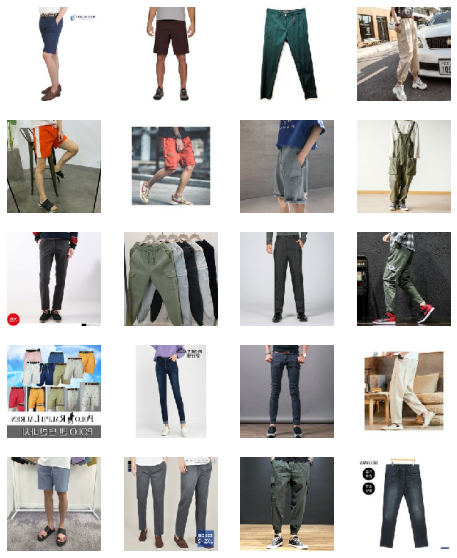

In [ ]:
plot_real_images(128)

In [ ]:
def training_datasets(resolution_log2, batch_size):
  """Build the training datasets up to a maximum resolution."""
  if resolution_log2 == 2:
    return [images_dataset(4, batch_size).as_numpy_iterator()]
  size = 1 << resolution_log2
  datasets = [images_dataset(size, batch_size)]
  datasets.append(datasets[0].map(
      lambda x: tf.image.resize(x, (size >> 1, size >> 1))))
  return [ds.as_numpy_iterator() for ds in datasets]


def training_data(resolution, batch_size):
  """Build a generator for training the discriminator."""
  resolution_log2 = int(np.log2(resolution))
  datasets = training_datasets(resolution_log2, batch_size)
  while True:
    try:
      data = tuple([next(ds) for ds in datasets])
      if len(data[0]) != batch_size:
        datasets = training_datasets(resolution_log2, batch_size)
        data = tuple([next(ds) for ds in datasets])
      yield data
    except StopIteration:
      datasets = training_datasets(resolution_log2, batch_size)

In [ ]:
def train_progan(gan, resolution,
                 total_kimg=1000,  # 1000s of images to show D.
                 transition_kimg=500,  # 1000s of images to fade in new layer.
                 checkpoint_path=None,  # Path to save weights.
                 print_every_n_batches=25,
                 alpha_min=0.0,  # Min and max for the mixing factor.
                 alpha_max=1.0,
                 save_every_n_batches=1000,
                 snapshot_every_n_batches=500,
                 **unused_kwargs):
  """Train ProGAN at a specific resolution."""
  batch_size = gan.batch_size

  total_img = 0
  n_batches = (total_kimg * 1000) // batch_size
  X_train = training_data(resolution, batch_size)

  resolution_log2 = int(np.log2(resolution))
  label = resolution_label(resolution_log2)
  alpha_batch = None

  for i in range(1, n_batches + 1):
    total_img += batch_size

    if resolution > 4 and transition_kimg != 0:
      alpha_batch = alpha_min
      alpha_batch += ((alpha_max - alpha_min)
                      * float(total_img) / (transition_kimg * 1000))
      alpha_batch = max(alpha_min, alpha_batch)
      alpha_batch = min(alpha_max, alpha_batch)
    elif resolution > 4:
      alpha_batch = 1.0

    X_batch = next(X_train)
    if alpha_batch is not None:
      X_batch = (fade_new_resolution(X_batch[0], alpha_batch), X_batch[1])
    
    print_loss = (i % print_every_n_batches) == 0
    if print_loss:
      print('Batch: {} / {}'.format(i, n_batches))
      if alpha_batch is not None:
        print('Alpha: {}'.format(alpha_batch))

    gan.models[label].train_on_batch(X_batch,
                                     alpha=alpha_batch,
                                     print_loss=print_loss)

    if (i % save_every_n_batches == 0 or i == n_batches) and checkpoint_path:
      print('Saving weights...')
      gan.save(resolution, checkpoint_path)
      print('Done.')
    
    # Every snaphot_every_n_batches batches we plot a snapshot of the model's
    # progress. Since evaluating the performance based on loss has been
    # difficult while I was experimenting with hyperparameters on my own.
    # The best way to evaluate the model is sampling G at each distribution.
    if i % snapshot_every_n_batches == 0:
      plot_generated_images(gan, resolution, alpha=alpha_batch)
      plt.show()


def plot_generated_images(gan,
                          resolution,
                          latents_in=None,
                          n_to_show=20,
                          n_rows=5,
                          figsize=(8, 10),
                          alpha=1.0):
  """Plot images made by a generator."""
  resolution_log2 = int(np.log2(resolution))

  latents_in = np.random.normal(size=(n_to_show, gan.latent_size))
  X_batch = gan.G[resolution_label(resolution_log2)].predict(latents_in)
  if resolution > 4:
    X_batch, X_prev = X_batch

  if alpha is not None and alpha != 1.0:
    X_prev = np.array(X_prev).repeat(2, axis=1).repeat(2, axis=2)
    X_batch = (alpha * X_batch) + ((1.0 - alpha) * X_prev)
  
  fig = plt.figure(figsize=(8, 10))

  for i, x in enumerate(X_batch):
    ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
    ax.axis('off')
    ax.imshow(np.clip(np.array(x).squeeze(), 0.0, 1.0),
              interpolation='antialiased')


def fade_new_resolution(x, alpha):
  """Just-in-time preprocessing of the real images adds crossfade between levels of detail."""
  s = x.shape
  y = tf.reshape(x, [-1, s[1] // 2, 2, s[2] // 2, 2, s[3]])
  y = tf.reduce_mean(y, axis=(2, 4))
  y = tf.keras.layers.UpSampling2D()(y)
  y = tf.reshape(y, [-1, *s[1:]])
  return y + (x - y) * alpha

In [ ]:
latents_test = np.random.normal(size=(64, 512))

Found 83205 files belonging to 1 classes.


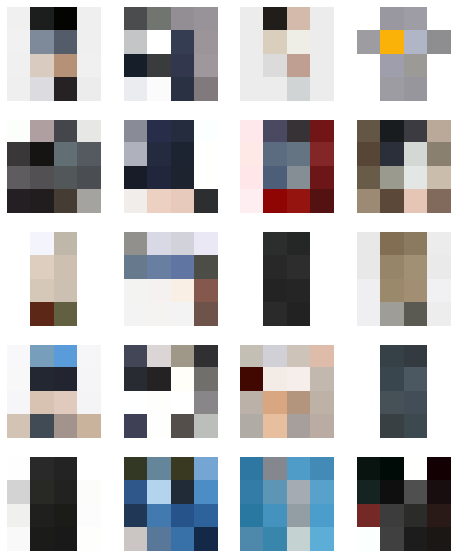

In [ ]:
plot_real_images(4)

In [ ]:
gan = ProGAN()

Found 83205 files belonging to 1 classes.
Batch: 25 / 7812
D Loss: R: -0.684738 F: 1.491818 GP: 1.774288
G Loss: -1.649534
Batch: 50 / 7812
D Loss: R: -1.676747 F: 3.097921 GP: 0.307733
G Loss: -3.118442
Batch: 75 / 7812
D Loss: R: -2.069129 F: 3.360314 GP: 0.215962
G Loss: -3.330243
Batch: 100 / 7812
D Loss: R: -1.195861 F: 1.720252 GP: 0.023268
G Loss: -1.629649
Batch: 125 / 7812
D Loss: R: -0.328435 F: 0.024553 GP: 0.580016
G Loss: -0.013832
Batch: 150 / 7812
D Loss: R: -0.380441 F: 1.590465 GP: 0.439640
G Loss: -1.548386
Batch: 175 / 7812
D Loss: R: -0.768826 F: 1.933082 GP: 0.179446
G Loss: -1.947978
Batch: 200 / 7812
D Loss: R: -1.778864 F: 2.129004 GP: 0.066634
G Loss: -2.126768
Batch: 225 / 7812
D Loss: R: -0.791867 F: 1.134261 GP: 0.012109
G Loss: -1.037452
Batch: 250 / 7812
D Loss: R: -0.052175 F: 1.377201 GP: 0.103292
G Loss: -1.371224
Batch: 275 / 7812
D Loss: R: -0.830948 F: 1.749727 GP: 0.031611
G Loss: -1.753965
Batch: 300 / 7812
D Loss: R: -1.799464 F: 2.629537 GP: 0.03

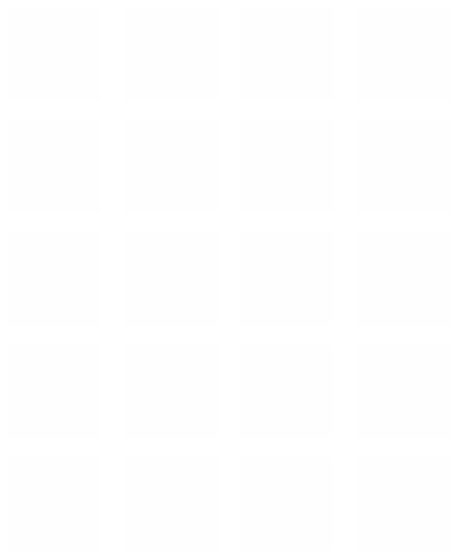

Batch: 525 / 7812
D Loss: R: 2.623323 F: -4.778902 GP: 0.104084
G Loss: 4.923549
Batch: 550 / 7812
D Loss: R: 2.721976 F: -3.732343 GP: 0.027214
G Loss: 3.828227
Batch: 575 / 7812
D Loss: R: -0.830308 F: 0.832846 GP: 0.915652
G Loss: -0.894847
Batch: 600 / 7812
D Loss: R: -0.918738 F: 2.607537 GP: 0.302410
G Loss: -2.227747
Batch: 625 / 7812
D Loss: R: -0.713064 F: 2.246579 GP: 0.212165
G Loss: -2.221511
Batch: 650 / 7812
D Loss: R: -0.341812 F: 1.166134 GP: 0.104389
G Loss: -1.106474
Found 83205 files belonging to 1 classes.
Batch: 675 / 7812
D Loss: R: 0.437598 F: -0.865932 GP: 0.060664
G Loss: 0.965615
Batch: 700 / 7812
D Loss: R: 1.994291 F: -2.043330 GP: 0.180760
G Loss: 2.106392
Batch: 725 / 7812
D Loss: R: 0.944966 F: -0.202960 GP: 1.171988
G Loss: 0.207012
Batch: 750 / 7812
D Loss: R: 0.322846 F: 0.494224 GP: 0.234672
G Loss: -0.576103
Batch: 775 / 7812
D Loss: R: -0.131762 F: 1.084587 GP: 0.114876
G Loss: -1.085822
Batch: 800 / 7812
D Loss: R: -0.415915 F: 1.300407 GP: 0.12049

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Done.


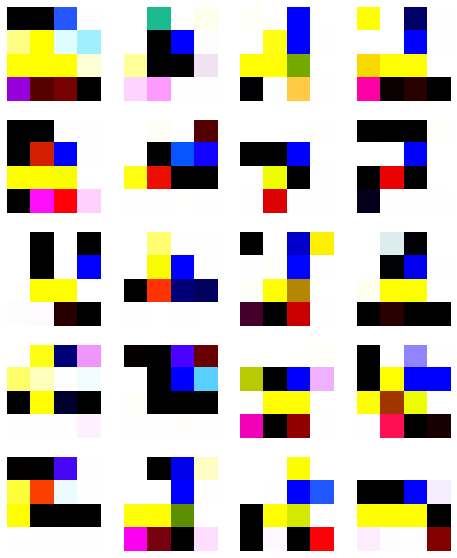

Batch: 1025 / 7812
D Loss: R: -0.516840 F: 1.455941 GP: 0.071729
G Loss: -1.472517
Batch: 1050 / 7812
D Loss: R: -0.412074 F: 1.226727 GP: 0.059872
G Loss: -1.213307
Batch: 1075 / 7812
D Loss: R: -0.002951 F: 0.798410 GP: 0.047396
G Loss: -0.759850
Batch: 1100 / 7812
D Loss: R: 0.157571 F: 0.413436 GP: 0.024645
G Loss: -0.320840
Batch: 1125 / 7812
D Loss: R: 0.438753 F: -0.040566 GP: 0.032549
G Loss: 0.025400
Batch: 1150 / 7812
D Loss: R: 0.678270 F: -0.441298 GP: 0.022923
G Loss: 0.429653
Batch: 1175 / 7812
D Loss: R: 0.591472 F: -0.252820 GP: 0.032433
G Loss: 0.292796
Batch: 1200 / 7812
D Loss: R: 0.617325 F: -0.295184 GP: 0.052572
G Loss: 0.359687
Batch: 1225 / 7812
D Loss: R: 0.410462 F: 0.131672 GP: 0.070679
G Loss: -0.078318
Batch: 1250 / 7812
D Loss: R: 0.653824 F: -0.073744 GP: 0.057958
G Loss: 0.140919
Batch: 1275 / 7812
D Loss: R: 0.720182 F: -0.313829 GP: 0.053782
G Loss: 0.318050
Batch: 1300 / 7812
D Loss: R: 0.726962 F: -0.507138 GP: 0.039583
G Loss: 0.535016
Found 83205 f

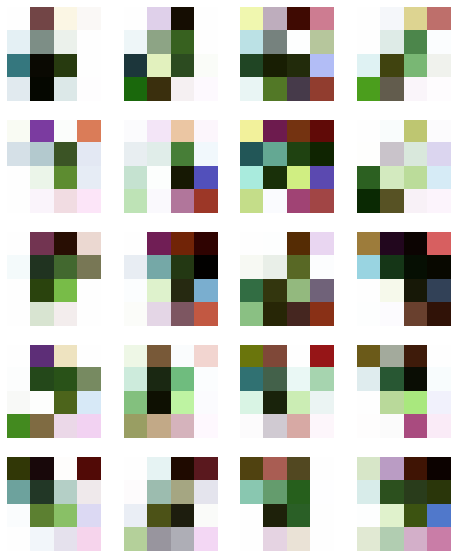

Batch: 1525 / 7812
D Loss: R: 0.880301 F: -0.790927 GP: 0.041749
G Loss: 0.787566
Batch: 1550 / 7812
D Loss: R: 0.864123 F: -0.685195 GP: 0.070166
G Loss: 0.714573
Batch: 1575 / 7812
D Loss: R: 0.820993 F: -0.490058 GP: 0.147372
G Loss: 0.639699
Batch: 1600 / 7812
D Loss: R: 1.005771 F: -0.975142 GP: 0.137343
G Loss: 1.035281
Batch: 1625 / 7812
D Loss: R: 0.996532 F: -0.960945 GP: 0.050187
G Loss: 0.970348
Batch: 1650 / 7812
D Loss: R: 1.046749 F: -0.979853 GP: 0.043372
G Loss: 1.022289
Batch: 1675 / 7812
D Loss: R: 0.992398 F: -0.846049 GP: 0.056924
G Loss: 0.938203
Batch: 1700 / 7812
D Loss: R: 0.912068 F: -0.641705 GP: 0.106968
G Loss: 0.702868
Batch: 1725 / 7812
D Loss: R: 0.748376 F: -0.655219 GP: 0.130729
G Loss: 0.758489
Batch: 1750 / 7812
D Loss: R: 0.752367 F: -0.630937 GP: 0.118042
G Loss: 0.661206
Batch: 1775 / 7812
D Loss: R: 0.841909 F: -0.762399 GP: 0.072923
G Loss: 0.776784
Batch: 1800 / 7812
D Loss: R: 0.793183 F: -0.722275 GP: 0.102058
G Loss: 0.745269
Batch: 1825 / 78

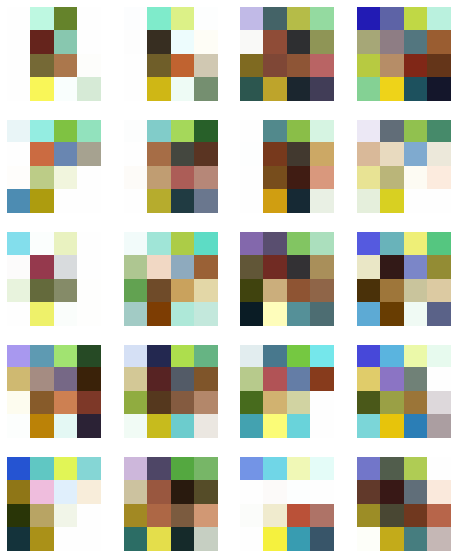

Batch: 2025 / 7812
D Loss: R: 0.733750 F: -0.727887 GP: 0.091538
G Loss: 0.870583
Batch: 2050 / 7812
D Loss: R: 0.734015 F: -0.653258 GP: 0.090163
G Loss: 0.599136
Batch: 2075 / 7812
D Loss: R: 0.572393 F: -0.478160 GP: 0.079467
G Loss: 0.507512
Batch: 2100 / 7812
D Loss: R: 0.616392 F: -0.251477 GP: 0.248372
G Loss: 0.172780
Batch: 2125 / 7812
D Loss: R: 0.715873 F: -0.274222 GP: 0.166125
G Loss: 0.421478
Batch: 2150 / 7812
D Loss: R: 0.897045 F: -0.519038 GP: 0.183988
G Loss: 0.518192
Batch: 2175 / 7812
D Loss: R: 1.094173 F: -1.023240 GP: 0.206512
G Loss: 1.182448
Batch: 2200 / 7812
D Loss: R: 1.140961 F: -1.185400 GP: 0.034855
G Loss: 1.227266
Batch: 2225 / 7812
D Loss: R: 1.472911 F: -1.515383 GP: 0.033577
G Loss: 1.571479
Batch: 2250 / 7812
D Loss: R: 1.519815 F: -1.370508 GP: 0.043368
G Loss: 1.342653
Batch: 2275 / 7812
D Loss: R: 0.929708 F: -0.672247 GP: 0.117237
G Loss: 0.702061
Batch: 2300 / 7812
D Loss: R: 0.604772 F: -0.459164 GP: 0.204939
G Loss: 0.588120
Batch: 2325 / 78

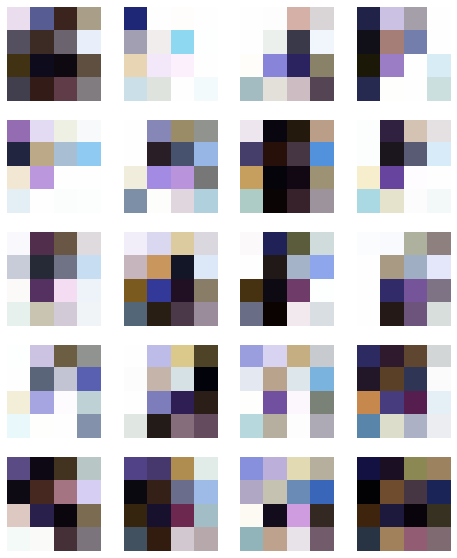

Batch: 2525 / 7812
D Loss: R: 0.817867 F: -0.680204 GP: 0.319497
G Loss: 0.729357
Batch: 2550 / 7812
D Loss: R: 1.076461 F: -1.045850 GP: 0.091787
G Loss: 1.123450
Batch: 2575 / 7812
D Loss: R: 1.088203 F: -0.989003 GP: 0.255631
G Loss: 0.962801
Batch: 2600 / 7812
D Loss: R: 0.922005 F: -0.750218 GP: 0.248336
G Loss: 0.845151
Found 83205 files belonging to 1 classes.
Batch: 2625 / 7812
D Loss: R: 0.716263 F: -0.605702 GP: 0.289541
G Loss: 0.687333
Batch: 2650 / 7812
D Loss: R: 0.846612 F: -0.821928 GP: 0.263518
G Loss: 0.907482
Batch: 2675 / 7812
D Loss: R: 1.060948 F: -0.979800 GP: 0.098221
G Loss: 0.976293
Batch: 2700 / 7812
D Loss: R: 1.195159 F: -1.170055 GP: 0.075318
G Loss: 1.183538
Batch: 2725 / 7812
D Loss: R: 1.368587 F: -1.455081 GP: 0.044166
G Loss: 1.478036
Batch: 2750 / 7812
D Loss: R: 1.742918 F: -1.919943 GP: 0.039246
G Loss: 1.935823
Batch: 2775 / 7812
D Loss: R: 2.339696 F: -2.558273 GP: 0.031692
G Loss: 2.521435
Batch: 2800 / 7812
D Loss: R: 1.562060 F: -1.457827 GP: 

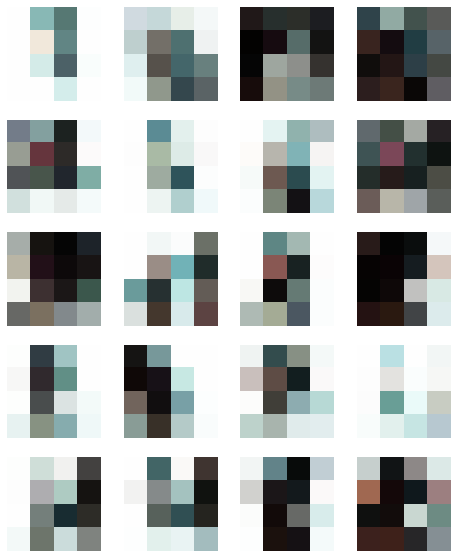

Batch: 3025 / 7812
D Loss: R: 1.302242 F: -1.176493 GP: 0.103874
G Loss: 1.232249
Batch: 3050 / 7812
D Loss: R: 1.048449 F: -0.944221 GP: 0.128816
G Loss: 0.918716
Batch: 3075 / 7812
D Loss: R: 0.957488 F: -0.842633 GP: 0.243105
G Loss: 0.895550
Batch: 3100 / 7812
D Loss: R: 0.788500 F: -0.794905 GP: 0.185785
G Loss: 0.912941
Batch: 3125 / 7812
D Loss: R: 1.018240 F: -0.971495 GP: 0.078426
G Loss: 1.014820
Batch: 3150 / 7812
D Loss: R: 1.070003 F: -0.908324 GP: 0.135558
G Loss: 0.961609
Batch: 3175 / 7812
D Loss: R: 1.030898 F: -0.934830 GP: 0.166858
G Loss: 0.915783
Batch: 3200 / 7812
D Loss: R: 0.955751 F: -0.923568 GP: 0.152125
G Loss: 0.913953
Batch: 3225 / 7812
D Loss: R: 0.515570 F: -0.441609 GP: 0.158636
G Loss: 0.486282
Batch: 3250 / 7812
D Loss: R: 0.449433 F: -0.371956 GP: 0.226887
G Loss: 0.329482
Found 83205 files belonging to 1 classes.
Batch: 3275 / 7812
D Loss: R: 0.813710 F: -0.786703 GP: 0.425853
G Loss: 0.763653
Batch: 3300 / 7812
D Loss: R: 0.856135 F: -0.818033 GP: 

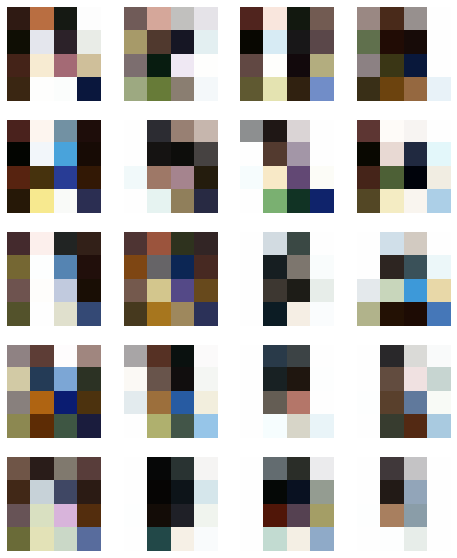

Batch: 3525 / 7812
D Loss: R: 0.198223 F: -0.220923 GP: 0.205158
G Loss: 0.341225
Batch: 3550 / 7812
D Loss: R: 0.282666 F: -0.235335 GP: 0.218457
G Loss: 0.187724
Batch: 3575 / 7812
D Loss: R: 0.252966 F: -0.200794 GP: 0.179121
G Loss: 0.208966
Batch: 3600 / 7812
D Loss: R: 0.434261 F: -0.331343 GP: 0.228060
G Loss: 0.383490
Batch: 3625 / 7812
D Loss: R: 0.571476 F: -0.536638 GP: 0.206328
G Loss: 0.536761
Batch: 3650 / 7812
D Loss: R: 0.661286 F: -0.607136 GP: 0.080259
G Loss: 0.645579
Batch: 3675 / 7812
D Loss: R: 0.582644 F: -0.544634 GP: 0.192111
G Loss: 0.463139
Batch: 3700 / 7812
D Loss: R: 0.492864 F: -0.460146 GP: 0.316904
G Loss: 0.468662
Batch: 3725 / 7812
D Loss: R: 0.522333 F: -0.481683 GP: 0.171715
G Loss: 0.521912
Batch: 3750 / 7812
D Loss: R: 0.321608 F: -0.293577 GP: 0.181329
G Loss: 0.241966
Batch: 3775 / 7812
D Loss: R: 0.496413 F: -0.440783 GP: 0.208559
G Loss: 0.514167
Batch: 3800 / 7812
D Loss: R: 0.269248 F: -0.234198 GP: 0.176944
G Loss: 0.209366
Batch: 3825 / 78

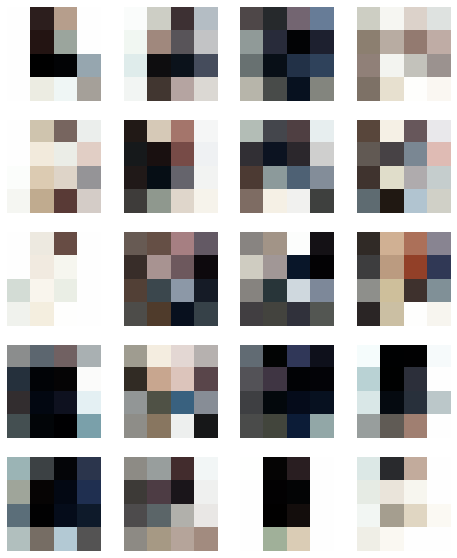

Batch: 4025 / 7812
D Loss: R: 0.271346 F: -0.193126 GP: 0.344647
G Loss: 0.184969
Batch: 4050 / 7812
D Loss: R: -0.110908 F: 0.108659 GP: 0.164912
G Loss: -0.074658
Batch: 4075 / 7812
D Loss: R: -0.131292 F: 0.204374 GP: 0.118897
G Loss: -0.076957
Batch: 4100 / 7812
D Loss: R: -0.142586 F: 0.155253 GP: 0.178730
G Loss: -0.108228
Batch: 4125 / 7812
D Loss: R: -0.339453 F: 0.389977 GP: 0.123925
G Loss: -0.358837
Batch: 4150 / 7812
D Loss: R: -0.287864 F: 0.333891 GP: 0.098236
G Loss: -0.259959
Batch: 4175 / 7812
D Loss: R: 0.286745 F: -0.245000 GP: 0.375828
G Loss: 0.265721
Batch: 4200 / 7812
D Loss: R: 0.041913 F: -0.026995 GP: 0.161095
G Loss: 0.041752
Batch: 4225 / 7812
D Loss: R: -0.172451 F: 0.187983 GP: 0.169545
G Loss: -0.247837
Batch: 4250 / 7812
D Loss: R: -0.358433 F: 0.376107 GP: 0.203345
G Loss: -0.363407
Batch: 4275 / 7812
D Loss: R: -0.490099 F: 0.502484 GP: 0.194632
G Loss: -0.555991
Batch: 4300 / 7812
D Loss: R: -0.514235 F: 0.537402 GP: 0.155455
G Loss: -0.552503
Batch: 

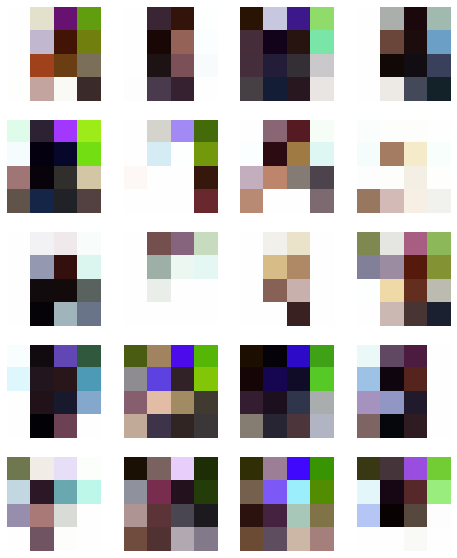

Batch: 4525 / 7812
D Loss: R: -0.264704 F: 0.283302 GP: 0.189155
G Loss: -0.242466
Batch: 4550 / 7812
D Loss: R: -0.168183 F: 0.225146 GP: 0.099649
G Loss: -0.135298
Found 83205 files belonging to 1 classes.
Batch: 4575 / 7812
D Loss: R: -0.628007 F: 0.633453 GP: 0.133787
G Loss: -0.510746
Batch: 4600 / 7812
D Loss: R: -0.594012 F: 0.599855 GP: 0.182698
G Loss: -0.574425
Batch: 4625 / 7812
D Loss: R: -0.465279 F: 0.470679 GP: 0.204064
G Loss: -0.369555
Batch: 4650 / 7812
D Loss: R: -0.530861 F: 0.560511 GP: 0.113845
G Loss: -0.561903
Batch: 4675 / 7812
D Loss: R: -0.571993 F: 0.608495 GP: 0.143409
G Loss: -0.619928
Batch: 4700 / 7812
D Loss: R: -0.846627 F: 0.857843 GP: 0.153483
G Loss: -0.933610
Batch: 4725 / 7812
D Loss: R: -0.808055 F: 0.815694 GP: 0.152862
G Loss: -0.712411
Batch: 4750 / 7812
D Loss: R: -0.913854 F: 0.970560 GP: 0.132041
G Loss: -1.030556
Batch: 4775 / 7812
D Loss: R: -0.655342 F: 0.732911 GP: 0.176467
G Loss: -0.751228
Batch: 4800 / 7812
D Loss: R: -0.729253 F: 0.

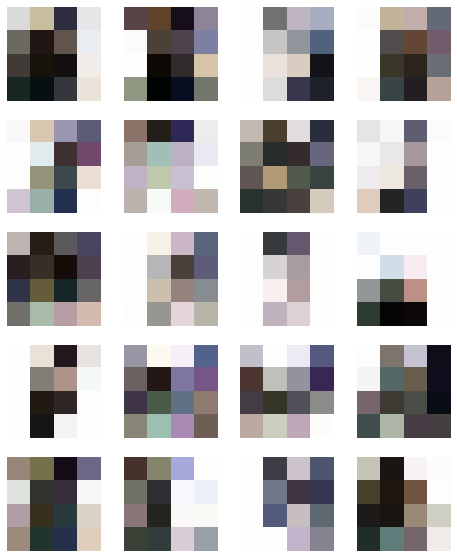

Batch: 5025 / 7812
D Loss: R: -1.123317 F: 1.130947 GP: 0.372102
G Loss: -1.413524
Batch: 5050 / 7812
D Loss: R: -0.995009 F: 0.971566 GP: 0.094916
G Loss: -1.071342
Batch: 5075 / 7812
D Loss: R: -1.032064 F: 1.059839 GP: 0.113426
G Loss: -1.151768
Batch: 5100 / 7812
D Loss: R: -1.154780 F: 1.183505 GP: 0.098458
G Loss: -1.345340
Batch: 5125 / 7812
D Loss: R: -1.295678 F: 1.326947 GP: 0.115602
G Loss: -1.287110
Batch: 5150 / 7812
D Loss: R: -1.303226 F: 1.266317 GP: 0.337015
G Loss: -1.421282
Batch: 5175 / 7812
D Loss: R: -1.401464 F: 1.390152 GP: 0.111960
G Loss: -1.247476
Batch: 5200 / 7812
D Loss: R: -1.612563 F: 1.690855 GP: 0.206128
G Loss: -1.788338
Found 83205 files belonging to 1 classes.
Batch: 5225 / 7812
D Loss: R: -1.625702 F: 1.694348 GP: 0.178572
G Loss: -1.608284
Batch: 5250 / 7812
D Loss: R: -1.732091 F: 1.757337 GP: 0.299578
G Loss: -1.693303
Batch: 5275 / 7812
D Loss: R: -1.583535 F: 1.590107 GP: 0.226453
G Loss: -1.869137
Batch: 5300 / 7812
D Loss: R: -1.559405 F: 1.

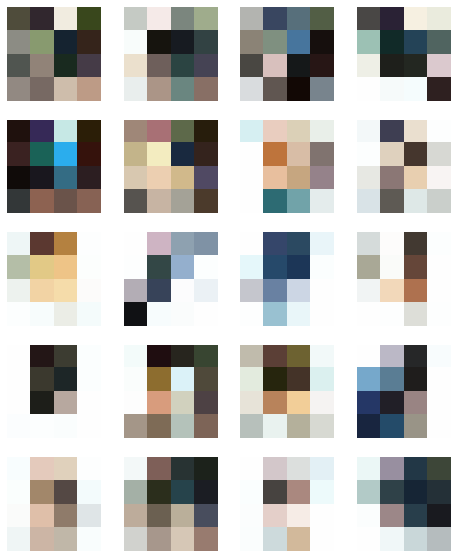

Batch: 5525 / 7812
D Loss: R: -1.995880 F: 2.002798 GP: 0.119945
G Loss: -2.076823
Batch: 5550 / 7812
D Loss: R: -1.673378 F: 1.697969 GP: 0.332464
G Loss: -1.863180
Batch: 5575 / 7812
D Loss: R: -1.867820 F: 1.945953 GP: 0.233740
G Loss: -1.875229
Batch: 5600 / 7812
D Loss: R: -2.171870 F: 2.121778 GP: 0.149652
G Loss: -2.301131
Batch: 5625 / 7812
D Loss: R: -2.368001 F: 2.377835 GP: 0.216689
G Loss: -2.473473
Batch: 5650 / 7812
D Loss: R: -1.930925 F: 1.992801 GP: 0.130697
G Loss: -2.121591
Batch: 5675 / 7812
D Loss: R: -2.152640 F: 2.233237 GP: 0.177874
G Loss: -2.293875
Batch: 5700 / 7812
D Loss: R: -1.960110 F: 2.027747 GP: 0.184066
G Loss: -1.959865
Batch: 5725 / 7812
D Loss: R: -2.356691 F: 2.370445 GP: 0.228002
G Loss: -2.498746
Batch: 5750 / 7812
D Loss: R: -2.086145 F: 2.138376 GP: 0.161614
G Loss: -2.065798
Batch: 5775 / 7812
D Loss: R: -2.405973 F: 2.426842 GP: 0.198586
G Loss: -2.546357
Batch: 5800 / 7812
D Loss: R: -2.652758 F: 2.761597 GP: 0.236385
G Loss: -2.576654
Batc

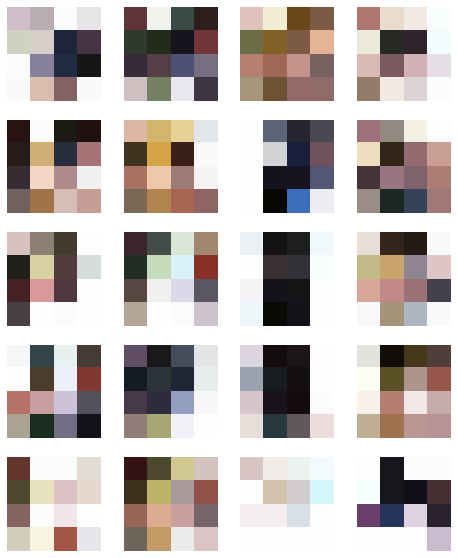

Batch: 6025 / 7812
D Loss: R: -3.458112 F: 3.458232 GP: 0.123385
G Loss: -3.350330
Batch: 6050 / 7812
D Loss: R: -3.372144 F: 3.405676 GP: 0.096702
G Loss: -3.203452
Batch: 6075 / 7812
D Loss: R: -3.386707 F: 3.399660 GP: 0.148837
G Loss: -3.639569
Batch: 6100 / 7812
D Loss: R: -3.466224 F: 3.462025 GP: 0.151016
G Loss: -3.622693
Batch: 6125 / 7812
D Loss: R: -3.348257 F: 3.292739 GP: 0.117485
G Loss: -3.341153
Batch: 6150 / 7812
D Loss: R: -3.305296 F: 3.346118 GP: 0.389801
G Loss: -3.470328
Batch: 6175 / 7812
D Loss: R: -3.248980 F: 3.318385 GP: 0.191560
G Loss: -3.122294
Batch: 6200 / 7812
D Loss: R: -3.415326 F: 3.481627 GP: 0.441789
G Loss: -3.618402
Batch: 6225 / 7812
D Loss: R: -3.664421 F: 3.664682 GP: 0.107215
G Loss: -3.604336
Batch: 6250 / 7812
D Loss: R: -3.671147 F: 3.675965 GP: 0.410268
G Loss: -3.706310
Batch: 6275 / 7812
D Loss: R: -3.579301 F: 3.615827 GP: 0.240167
G Loss: -3.877356
Batch: 6300 / 7812
D Loss: R: -3.942810 F: 3.966668 GP: 0.160666
G Loss: -4.091486
Batc

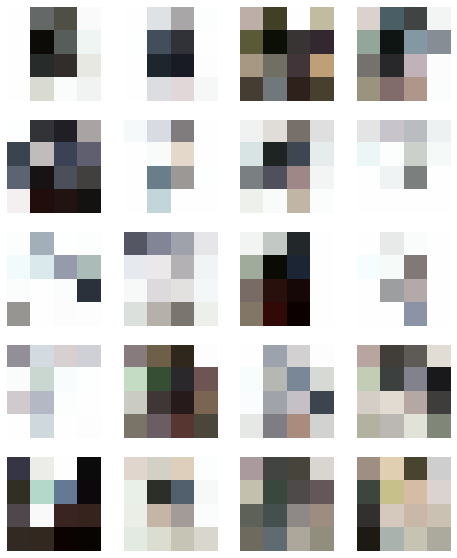

Found 83205 files belonging to 1 classes.
Batch: 6525 / 7812
D Loss: R: -4.891981 F: 4.881476 GP: 0.204673
G Loss: -4.976147
Batch: 6550 / 7812
D Loss: R: -4.694520 F: 4.699455 GP: 0.267198
G Loss: -4.673942
Batch: 6575 / 7812
D Loss: R: -4.921289 F: 4.927227 GP: 0.208662
G Loss: -5.080426
Batch: 6600 / 7812
D Loss: R: -4.976535 F: 5.027310 GP: 0.164812
G Loss: -5.061542
Batch: 6625 / 7812
D Loss: R: -5.474951 F: 5.520324 GP: 0.141349
G Loss: -5.440806
Batch: 6650 / 7812
D Loss: R: -5.173717 F: 5.071941 GP: 0.185799
G Loss: -5.353599
Batch: 6675 / 7812
D Loss: R: -5.186638 F: 5.164222 GP: 0.182900
G Loss: -5.167656
Batch: 6700 / 7812
D Loss: R: -5.324829 F: 5.355174 GP: 0.189412
G Loss: -5.088216
Batch: 6725 / 7812
D Loss: R: -5.000469 F: 5.049597 GP: 0.192274
G Loss: -5.188752
Batch: 6750 / 7812
D Loss: R: -5.716503 F: 5.778742 GP: 0.302687
G Loss: -5.639556
Batch: 6775 / 7812
D Loss: R: -5.829263 F: 5.840923 GP: 0.194179
G Loss: -5.903486
Batch: 6800 / 7812
D Loss: R: -6.022063 F: 6.

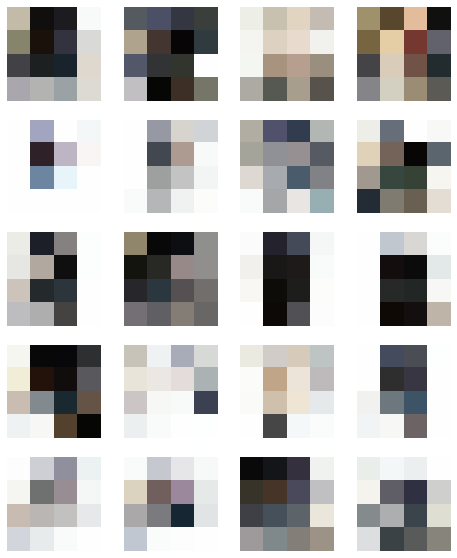

Batch: 7025 / 7812
D Loss: R: -6.292027 F: 6.352911 GP: 0.130404
G Loss: -6.208439
Batch: 7050 / 7812
D Loss: R: -6.208388 F: 6.221330 GP: 0.169629
G Loss: -6.223781
Batch: 7075 / 7812
D Loss: R: -6.377512 F: 6.321307 GP: 0.108036
G Loss: -6.471023
Batch: 7100 / 7812
D Loss: R: -7.384418 F: 7.292891 GP: 0.280123
G Loss: -7.394331
Batch: 7125 / 7812
D Loss: R: -6.969859 F: 7.006056 GP: 0.128172
G Loss: -6.958790
Batch: 7150 / 7812
D Loss: R: -6.251743 F: 6.286860 GP: 0.090160
G Loss: -6.247102
Found 83205 files belonging to 1 classes.
Batch: 7175 / 7812
D Loss: R: -5.983638 F: 6.060370 GP: 0.229925
G Loss: -6.171709
Batch: 7200 / 7812
D Loss: R: -6.405399 F: 6.364293 GP: 0.189710
G Loss: -6.445542
Batch: 7225 / 7812
D Loss: R: -6.272490 F: 6.222752 GP: 0.124201
G Loss: -6.385853
Batch: 7250 / 7812
D Loss: R: -6.133206 F: 6.146013 GP: 0.184422
G Loss: -6.209525
Batch: 7275 / 7812
D Loss: R: -6.539310 F: 6.578248 GP: 0.126931
G Loss: -6.833027
Batch: 7300 / 7812
D Loss: R: -7.057418 F: 7.

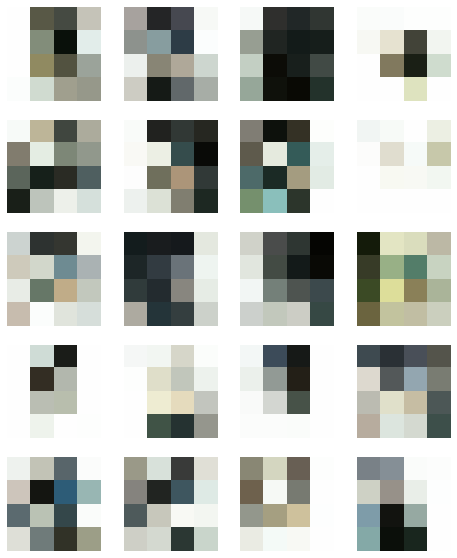

Batch: 7525 / 7812
D Loss: R: -8.740748 F: 8.805449 GP: 0.255583
G Loss: -9.049402
Batch: 7550 / 7812
D Loss: R: -8.644392 F: 8.678302 GP: 0.136609
G Loss: -8.501394
Batch: 7575 / 7812
D Loss: R: -8.297398 F: 8.291810 GP: 0.088597
G Loss: -8.302337
Batch: 7600 / 7812
D Loss: R: -8.197512 F: 8.147121 GP: 0.138010
G Loss: -8.323462
Batch: 7625 / 7812
D Loss: R: -8.663145 F: 8.765090 GP: 0.230245
G Loss: -8.610285
Batch: 7650 / 7812
D Loss: R: -9.031761 F: 9.125532 GP: 0.106562
G Loss: -8.795203
Batch: 7675 / 7812
D Loss: R: -8.141071 F: 8.140026 GP: 0.109083
G Loss: -8.102501
Batch: 7700 / 7812
D Loss: R: -8.324834 F: 8.389285 GP: 0.156770
G Loss: -8.372623
Batch: 7725 / 7812
D Loss: R: -7.806665 F: 7.786302 GP: 0.067067
G Loss: -7.721721
Batch: 7750 / 7812
D Loss: R: -8.546463 F: 8.582489 GP: 0.326188
G Loss: -8.256947
Batch: 7775 / 7812
D Loss: R: -9.437748 F: 9.532759 GP: 0.122603
G Loss: -9.386623
Batch: 7800 / 7812
D Loss: R: -8.656949 F: 8.696140 GP: 0.137899
G Loss: -8.391389
Foun

In [ ]:
train_progan(gan, 4,
             checkpoint_path=base_dir+'4x4/',
             total_kimg=1000) 

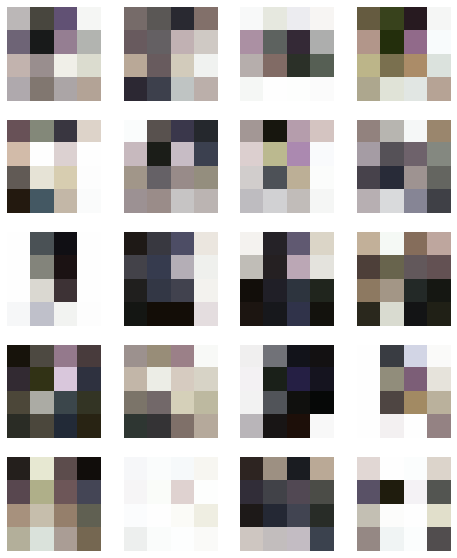

In [ ]:
gan.load(4, base_dir+'4x4/')
plot_generated_images(gan, 4, latents_in=latents_test)

Found 83205 files belonging to 1 classes.


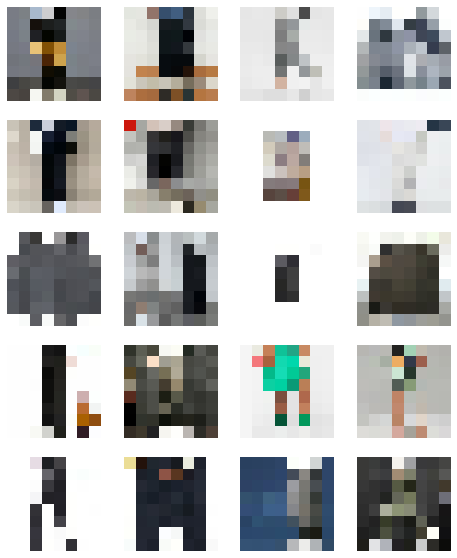

In [ ]:
plot_real_images(8)

In [ ]:
gan = ProGAN()

In [ ]:
gan.load(4, base_dir+'4x4/')
gan.transfer_previous_resolution_weights(8)

Copied 17307652 parameters to the higher resolution model.


Found 83205 files belonging to 1 classes.
Batch: 25 / 15625
Alpha: 0.005333333333333333
D Loss: R: -4.485237 F: 4.117787 GP: 2.828622
G Loss: -3.552183
Batch: 50 / 15625
Alpha: 0.010666666666666666
D Loss: R: -3.436213 F: 3.525454 GP: 0.092671
G Loss: -3.199469
Batch: 75 / 15625
Alpha: 0.016
D Loss: R: -3.202328 F: 3.244314 GP: 0.104094
G Loss: -3.579576
Batch: 100 / 15625
Alpha: 0.021333333333333333
D Loss: R: -5.383578 F: 5.593686 GP: 0.733812
G Loss: -5.003495
Batch: 125 / 15625
Alpha: 0.02666666666666667
D Loss: R: -8.585282 F: 8.757958 GP: 1.026456
G Loss: -7.812565
Batch: 150 / 15625
Alpha: 0.032
D Loss: R: -9.340805 F: 9.405739 GP: 0.562317
G Loss: -8.461344
Batch: 175 / 15625
Alpha: 0.037333333333333336
D Loss: R: -9.357892 F: 9.395802 GP: 0.412454
G Loss: -10.628321
Batch: 200 / 15625
Alpha: 0.042666666666666665
D Loss: R: -9.583745 F: 9.804295 GP: 0.319695
G Loss: -10.161430
Batch: 225 / 15625
Alpha: 0.048
D Loss: R: -10.588262 F: 10.952187 GP: 0.182677
G Loss: -10.671512
Bat

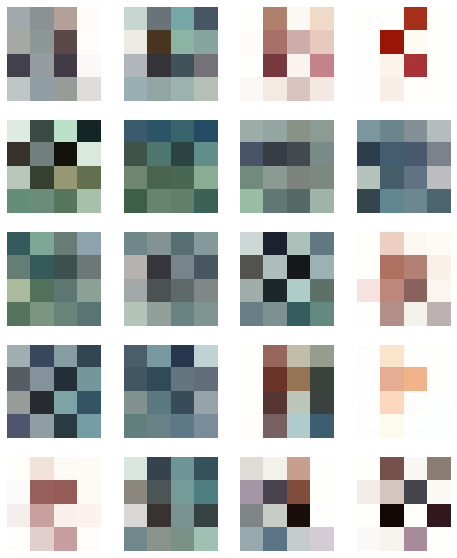

Batch: 525 / 15625
Alpha: 0.112
D Loss: R: -14.739488 F: 12.615410 GP: 0.410590
G Loss: -13.810452
Batch: 550 / 15625
Alpha: 0.11733333333333333
D Loss: R: -16.537598 F: 14.427318 GP: 0.597080
G Loss: -12.616513
Batch: 575 / 15625
Alpha: 0.12266666666666666
D Loss: R: -15.695217 F: 14.007057 GP: 0.368629
G Loss: -14.013993
Batch: 600 / 15625
Alpha: 0.128
D Loss: R: -16.627903 F: 14.801831 GP: 0.610923
G Loss: -15.534355
Batch: 625 / 15625
Alpha: 0.13333333333333333
D Loss: R: -16.726074 F: 14.673740 GP: 0.614767
G Loss: -14.233269
Batch: 650 / 15625
Alpha: 0.13866666666666666
D Loss: R: -16.838293 F: 14.707143 GP: 0.638332
G Loss: -14.332657
Found 83205 files belonging to 1 classes.
Batch: 675 / 15625
Alpha: 0.144
D Loss: R: -17.500195 F: 15.161727 GP: 0.609465
G Loss: -13.753608
Batch: 700 / 15625
Alpha: 0.14933333333333335
D Loss: R: -16.810883 F: 14.901988 GP: 0.763825
G Loss: -13.143727
Batch: 725 / 15625
Alpha: 0.15466666666666667
D Loss: R: -16.399096 F: 14.177993 GP: 0.702631
G 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Done.


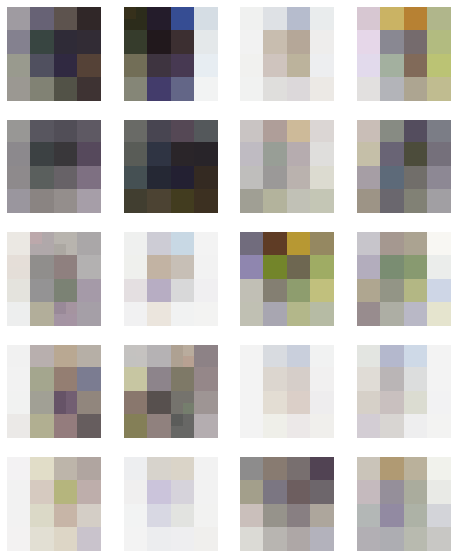

Batch: 1025 / 15625
Alpha: 0.21866666666666668
D Loss: R: -21.364975 F: 19.195736 GP: 0.643535
G Loss: -17.475576
Batch: 1050 / 15625
Alpha: 0.224
D Loss: R: -21.402580 F: 18.738598 GP: 0.459172
G Loss: -18.016592
Batch: 1075 / 15625
Alpha: 0.22933333333333333
D Loss: R: -20.819447 F: 18.086998 GP: 0.396224
G Loss: -17.871758
Batch: 1100 / 15625
Alpha: 0.23466666666666666
D Loss: R: -20.633003 F: 18.253265 GP: 0.422673
G Loss: -17.619654
Batch: 1125 / 15625
Alpha: 0.24
D Loss: R: -19.807388 F: 18.072157 GP: 0.362904
G Loss: -17.568813
Batch: 1150 / 15625
Alpha: 0.24533333333333332
D Loss: R: -21.318871 F: 18.650837 GP: 0.401764
G Loss: -18.569613
Batch: 1175 / 15625
Alpha: 0.25066666666666665
D Loss: R: -20.551979 F: 17.924805 GP: 0.710129
G Loss: -17.863049
Batch: 1200 / 15625
Alpha: 0.256
D Loss: R: -19.845356 F: 17.512495 GP: 0.763064
G Loss: -17.776115
Batch: 1225 / 15625
Alpha: 0.2613333333333333
D Loss: R: -18.420319 F: 16.282736 GP: 0.238742
G Loss: -16.895412
Batch: 1250 / 1562

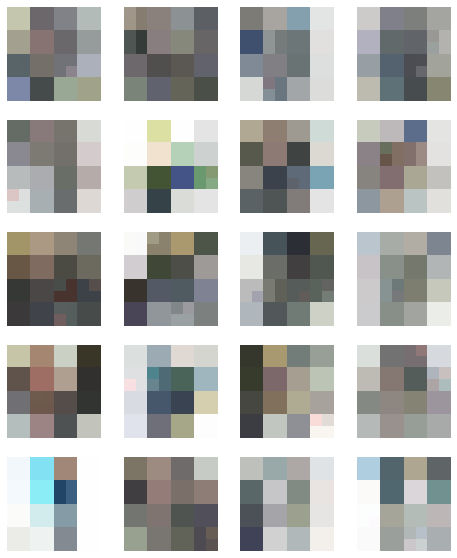

Batch: 1525 / 15625
Alpha: 0.3253333333333333
D Loss: R: -15.604557 F: 13.516568 GP: 0.525433
G Loss: -13.805740
Batch: 1550 / 15625
Alpha: 0.33066666666666666
D Loss: R: -15.555128 F: 13.552275 GP: 0.307592
G Loss: -13.815456
Batch: 1575 / 15625
Alpha: 0.336
D Loss: R: -15.791110 F: 13.946125 GP: 0.320789
G Loss: -13.633638
Batch: 1600 / 15625
Alpha: 0.3413333333333333
D Loss: R: -15.748275 F: 13.954891 GP: 0.288066
G Loss: -12.633544
Batch: 1625 / 15625
Alpha: 0.3466666666666667
D Loss: R: -15.096817 F: 13.421124 GP: 0.215925
G Loss: -13.995941
Batch: 1650 / 15625
Alpha: 0.352
D Loss: R: -15.862870 F: 14.114359 GP: 0.280823
G Loss: -14.546782
Batch: 1675 / 15625
Alpha: 0.35733333333333334
D Loss: R: -14.071214 F: 12.120594 GP: 0.277010
G Loss: -13.206781
Batch: 1700 / 15625
Alpha: 0.3626666666666667
D Loss: R: -13.179737 F: 11.803134 GP: 0.236224
G Loss: -12.577148
Batch: 1725 / 15625
Alpha: 0.368
D Loss: R: -14.089836 F: 12.734250 GP: 0.236192
G Loss: -11.501627
Batch: 1750 / 15625


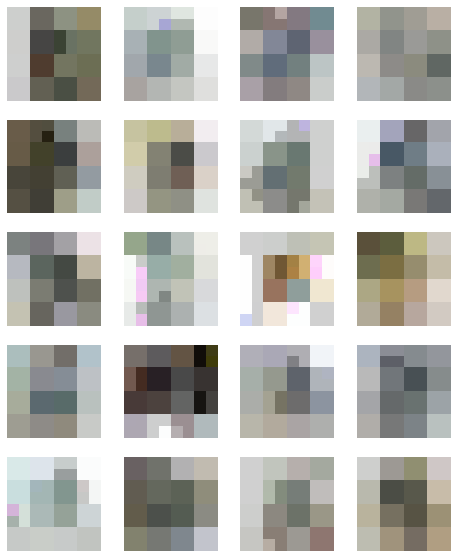

Batch: 2025 / 15625
Alpha: 0.432
D Loss: R: -12.995872 F: 11.831986 GP: 0.245544
G Loss: -11.734838
Batch: 2050 / 15625
Alpha: 0.43733333333333335
D Loss: R: -12.808332 F: 11.888912 GP: 0.592169
G Loss: -13.770279
Batch: 2075 / 15625
Alpha: 0.44266666666666665
D Loss: R: -14.032241 F: 12.856279 GP: 0.218692
G Loss: -11.594815
Batch: 2100 / 15625
Alpha: 0.448
D Loss: R: -13.556042 F: 12.480885 GP: 0.256191
G Loss: -12.271882
Batch: 2125 / 15625
Alpha: 0.4533333333333333
D Loss: R: -12.906666 F: 11.951536 GP: 0.198695
G Loss: -11.786653
Batch: 2150 / 15625
Alpha: 0.45866666666666667
D Loss: R: -12.778608 F: 11.805584 GP: 0.186323
G Loss: -12.516304
Batch: 2175 / 15625
Alpha: 0.464
D Loss: R: -12.040634 F: 11.216303 GP: 0.195422
G Loss: -12.312982
Batch: 2200 / 15625
Alpha: 0.4693333333333333
D Loss: R: -12.269988 F: 11.353952 GP: 0.194066
G Loss: -11.014900
Batch: 2225 / 15625
Alpha: 0.4746666666666667
D Loss: R: -11.791924 F: 10.885816 GP: 0.149664
G Loss: -11.144377
Batch: 2250 / 15625

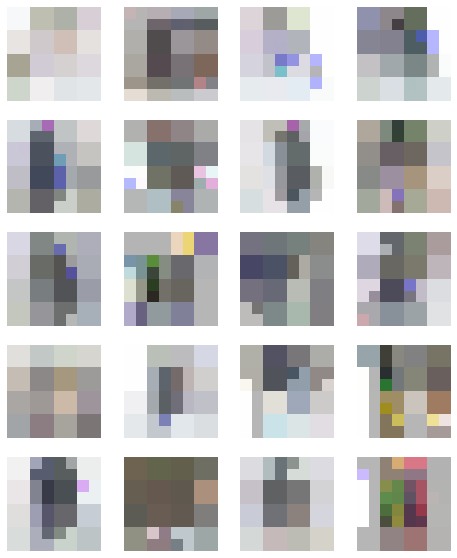

Batch: 2525 / 15625
Alpha: 0.5386666666666666
D Loss: R: -11.746909 F: 11.019493 GP: 0.169048
G Loss: -10.988296
Batch: 2550 / 15625
Alpha: 0.544
D Loss: R: -11.659298 F: 11.058712 GP: 0.230953
G Loss: -10.898716
Batch: 2575 / 15625
Alpha: 0.5493333333333333
D Loss: R: -12.360893 F: 11.566082 GP: 0.177152
G Loss: -11.292729
Batch: 2600 / 15625
Alpha: 0.5546666666666666
D Loss: R: -12.959686 F: 12.266905 GP: 0.110869
G Loss: -12.198593
Found 83205 files belonging to 1 classes.
Batch: 2625 / 15625
Alpha: 0.56
D Loss: R: -11.821108 F: 11.328931 GP: 0.306029
G Loss: -10.728586
Batch: 2650 / 15625
Alpha: 0.5653333333333334
D Loss: R: -12.331652 F: 11.421322 GP: 0.207754
G Loss: -12.485344
Batch: 2675 / 15625
Alpha: 0.5706666666666667
D Loss: R: -12.525409 F: 11.601027 GP: 0.209371
G Loss: -11.553408
Batch: 2700 / 15625
Alpha: 0.576
D Loss: R: -12.519783 F: 11.783118 GP: 0.258483
G Loss: -11.058312
Batch: 2725 / 15625
Alpha: 0.5813333333333334
D Loss: R: -11.123110 F: 10.764484 GP: 0.285836


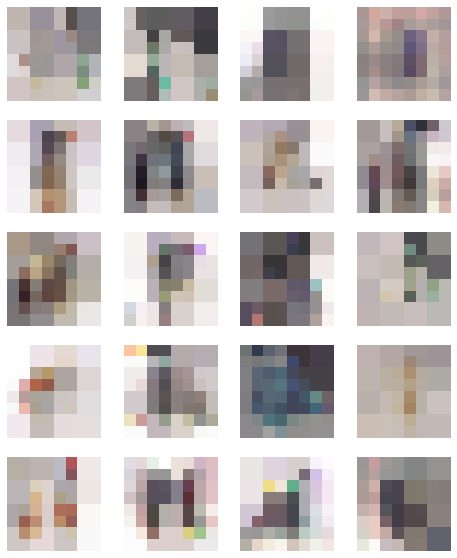

Batch: 3025 / 15625
Alpha: 0.6453333333333333
D Loss: R: -9.477698 F: 9.114447 GP: 0.107578
G Loss: -8.749874
Batch: 3050 / 15625
Alpha: 0.6506666666666666
D Loss: R: -9.167152 F: 9.132002 GP: 0.277795
G Loss: -9.059332
Batch: 3075 / 15625
Alpha: 0.656
D Loss: R: -8.771820 F: 8.493849 GP: 0.368074
G Loss: -8.513427
Batch: 3100 / 15625
Alpha: 0.6613333333333333
D Loss: R: -9.225147 F: 8.943058 GP: 0.160478
G Loss: -9.352372
Batch: 3125 / 15625
Alpha: 0.6666666666666666
D Loss: R: -9.806003 F: 9.479565 GP: 0.127900
G Loss: -9.318941
Batch: 3150 / 15625
Alpha: 0.672
D Loss: R: -9.634111 F: 9.366829 GP: 0.105198
G Loss: -9.234282
Batch: 3175 / 15625
Alpha: 0.6773333333333333
D Loss: R: -8.827776 F: 8.495599 GP: 0.106566
G Loss: -8.850414
Batch: 3200 / 15625
Alpha: 0.6826666666666666
D Loss: R: -10.540606 F: 10.396461 GP: 0.120649
G Loss: -9.268517
Batch: 3225 / 15625
Alpha: 0.688
D Loss: R: -8.941710 F: 8.609290 GP: 0.145057
G Loss: -8.589355
Batch: 3250 / 15625
Alpha: 0.6933333333333334
D

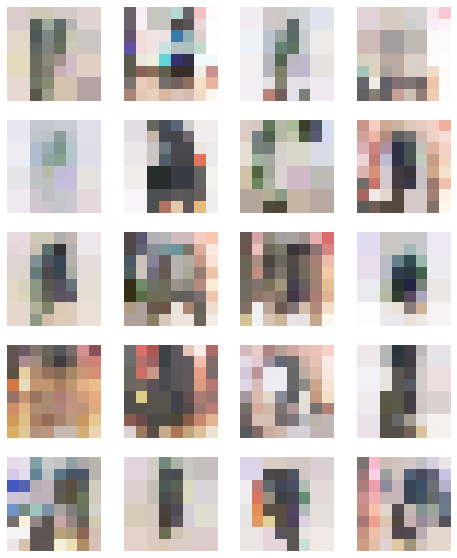

Batch: 3525 / 15625
Alpha: 0.752
D Loss: R: -10.462063 F: 10.162950 GP: 0.140693
G Loss: -9.656616
Batch: 3550 / 15625
Alpha: 0.7573333333333333
D Loss: R: -10.014598 F: 9.742226 GP: 0.105812
G Loss: -8.905655
Batch: 3575 / 15625
Alpha: 0.7626666666666667
D Loss: R: -8.700061 F: 8.388504 GP: 0.097108
G Loss: -7.985554
Batch: 3600 / 15625
Alpha: 0.768
D Loss: R: -9.215540 F: 8.823518 GP: 0.078731
G Loss: -8.549107
Batch: 3625 / 15625
Alpha: 0.7733333333333333
D Loss: R: -8.828647 F: 8.530693 GP: 0.093158
G Loss: -7.949508
Batch: 3650 / 15625
Alpha: 0.7786666666666666
D Loss: R: -9.181224 F: 8.874222 GP: 0.091373
G Loss: -9.291205
Batch: 3675 / 15625
Alpha: 0.784
D Loss: R: -9.509349 F: 9.444940 GP: 0.097133
G Loss: -8.896534
Batch: 3700 / 15625
Alpha: 0.7893333333333333
D Loss: R: -8.588799 F: 8.435255 GP: 0.114970
G Loss: -8.522255
Batch: 3725 / 15625
Alpha: 0.7946666666666666
D Loss: R: -8.779864 F: 8.470699 GP: 0.131561
G Loss: -8.406971
Batch: 3750 / 15625
Alpha: 0.8
D Loss: R: -8.6

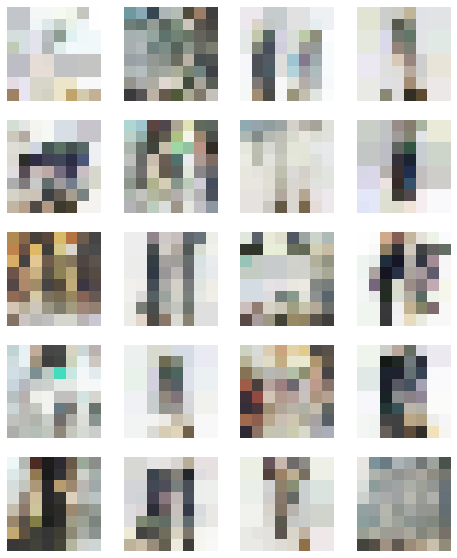

Batch: 4025 / 15625
Alpha: 0.8586666666666667
D Loss: R: -7.063102 F: 6.892009 GP: 0.165998
G Loss: -7.207440
Batch: 4050 / 15625
Alpha: 0.864
D Loss: R: -8.439482 F: 8.262770 GP: 0.135241
G Loss: -7.945119
Batch: 4075 / 15625
Alpha: 0.8693333333333333
D Loss: R: -7.268324 F: 7.176925 GP: 0.348015
G Loss: -7.494307
Batch: 4100 / 15625
Alpha: 0.8746666666666667
D Loss: R: -7.996979 F: 7.855876 GP: 0.092934
G Loss: -7.864995
Batch: 4125 / 15625
Alpha: 0.88
D Loss: R: -7.412786 F: 7.581625 GP: 0.096344
G Loss: -7.277717
Batch: 4150 / 15625
Alpha: 0.8853333333333333
D Loss: R: -7.635387 F: 7.464266 GP: 0.091893
G Loss: -7.270642
Batch: 4175 / 15625
Alpha: 0.8906666666666667
D Loss: R: -8.652533 F: 8.390446 GP: 0.075454
G Loss: -8.108238
Batch: 4200 / 15625
Alpha: 0.896
D Loss: R: -5.953919 F: 5.842658 GP: 0.060220
G Loss: -5.786321
Batch: 4225 / 15625
Alpha: 0.9013333333333333
D Loss: R: -7.797863 F: 7.666598 GP: 0.084212
G Loss: -7.287580
Batch: 4250 / 15625
Alpha: 0.9066666666666666
D Lo

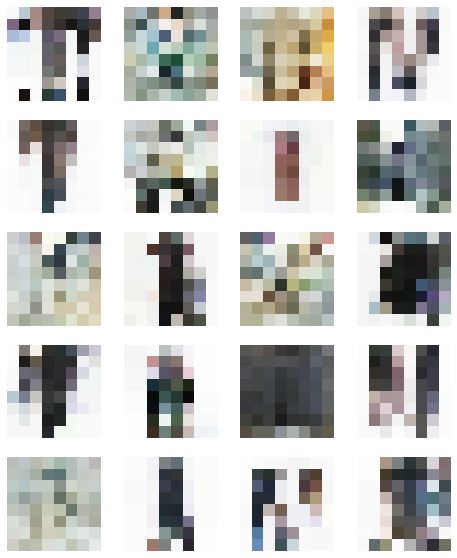

Batch: 4525 / 15625
Alpha: 0.9653333333333334
D Loss: R: -7.100289 F: 7.112176 GP: 0.090391
G Loss: -6.391207
Batch: 4550 / 15625
Alpha: 0.9706666666666667
D Loss: R: -6.004032 F: 5.772273 GP: 0.087249
G Loss: -6.386977
Found 83205 files belonging to 1 classes.
Batch: 4575 / 15625
Alpha: 0.976
D Loss: R: -6.457133 F: 6.149230 GP: 0.085040
G Loss: -5.935079
Batch: 4600 / 15625
Alpha: 0.9813333333333333
D Loss: R: -5.244252 F: 5.176762 GP: 0.109371
G Loss: -5.568326
Batch: 4625 / 15625
Alpha: 0.9866666666666667
D Loss: R: -5.802383 F: 5.638143 GP: 0.093756
G Loss: -6.201871
Batch: 4650 / 15625
Alpha: 0.992
D Loss: R: -5.437144 F: 5.385765 GP: 0.296772
G Loss: -5.143377
Batch: 4675 / 15625
Alpha: 0.9973333333333333
D Loss: R: -5.642084 F: 5.558395 GP: 0.084689
G Loss: -5.149871
Batch: 4700 / 15625
Alpha: 1.0
D Loss: R: -5.601295 F: 5.424698 GP: 0.079705
G Loss: -5.104541
Batch: 4725 / 15625
Alpha: 1.0
D Loss: R: -4.974862 F: 4.712217 GP: 0.100970
G Loss: -4.705751
Batch: 4750 / 15625
Alph

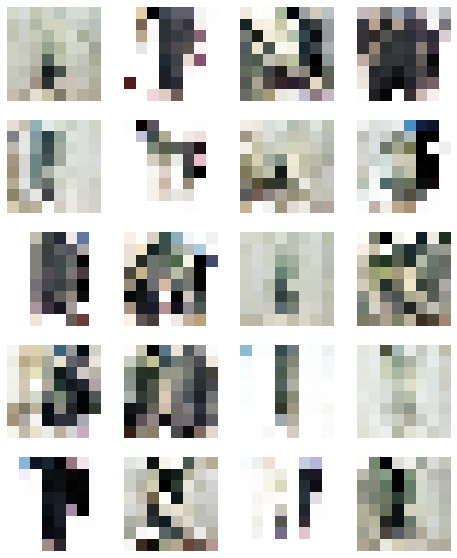

Batch: 5025 / 15625
Alpha: 1.0
D Loss: R: -9.214148 F: 9.303261 GP: 0.142637
G Loss: -8.490954
Batch: 5050 / 15625
Alpha: 1.0
D Loss: R: -9.793371 F: 9.926014 GP: 0.081177
G Loss: -10.451558
Batch: 5075 / 15625
Alpha: 1.0
D Loss: R: -11.802696 F: 11.862019 GP: 0.110755
G Loss: -11.475572
Batch: 5100 / 15625
Alpha: 1.0
D Loss: R: -11.563604 F: 11.373251 GP: 0.137861
G Loss: -11.205221
Batch: 5125 / 15625
Alpha: 1.0
D Loss: R: -14.283681 F: 14.145542 GP: 0.094912
G Loss: -14.269617
Batch: 5150 / 15625
Alpha: 1.0
D Loss: R: -15.484282 F: 15.203930 GP: 0.324351
G Loss: -14.675365
Batch: 5175 / 15625
Alpha: 1.0
D Loss: R: -14.112167 F: 14.010696 GP: 0.075693
G Loss: -13.813089
Batch: 5200 / 15625
Alpha: 1.0
D Loss: R: -11.772564 F: 11.566689 GP: 0.117138
G Loss: -11.212849
Found 83205 files belonging to 1 classes.
Batch: 5225 / 15625
Alpha: 1.0
D Loss: R: -9.888766 F: 9.717752 GP: 0.093888
G Loss: -9.702225
Batch: 5250 / 15625
Alpha: 1.0
D Loss: R: -9.161942 F: 8.980544 GP: 0.127136
G Loss:

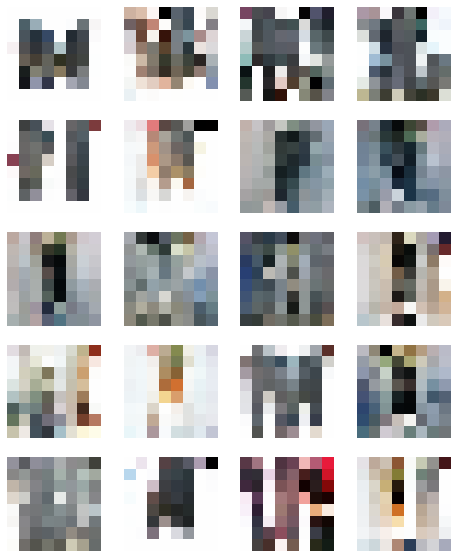

Batch: 5525 / 15625
Alpha: 1.0
D Loss: R: -5.947262 F: 5.752999 GP: 0.249792
G Loss: -4.832379
Batch: 5550 / 15625
Alpha: 1.0
D Loss: R: -5.541310 F: 5.262820 GP: 0.111673
G Loss: -5.379996
Batch: 5575 / 15625
Alpha: 1.0
D Loss: R: -5.040312 F: 4.832726 GP: 0.134937
G Loss: -5.029278
Batch: 5600 / 15625
Alpha: 1.0
D Loss: R: -5.015465 F: 4.762686 GP: 0.083024
G Loss: -4.959352
Batch: 5625 / 15625
Alpha: 1.0
D Loss: R: -5.125936 F: 5.208109 GP: 0.104206
G Loss: -4.391055
Batch: 5650 / 15625
Alpha: 1.0
D Loss: R: -5.246616 F: 5.058661 GP: 0.146394
G Loss: -5.034483
Batch: 5675 / 15625
Alpha: 1.0
D Loss: R: -5.288897 F: 5.137278 GP: 0.159056
G Loss: -4.790838
Batch: 5700 / 15625
Alpha: 1.0
D Loss: R: -4.505618 F: 4.367733 GP: 0.310965
G Loss: -4.728253
Batch: 5725 / 15625
Alpha: 1.0
D Loss: R: -4.434289 F: 4.245344 GP: 0.102271
G Loss: -4.258644
Batch: 5750 / 15625
Alpha: 1.0
D Loss: R: -6.404634 F: 7.071414 GP: 0.443175
G Loss: -6.828256
Batch: 5775 / 15625
Alpha: 1.0
D Loss: R: -7.11993

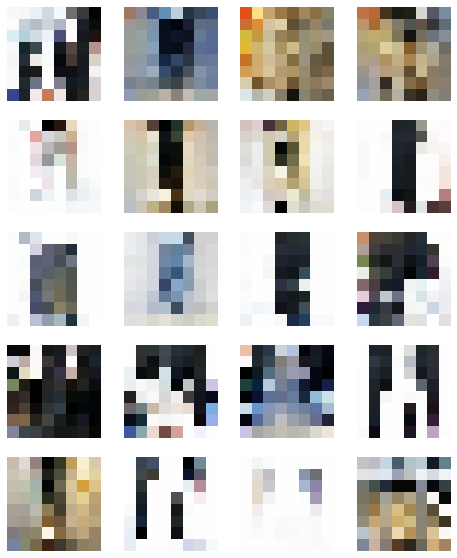

Batch: 6025 / 15625
Alpha: 1.0
D Loss: R: -5.151184 F: 4.927976 GP: 0.098752
G Loss: -5.376143
Batch: 6050 / 15625
Alpha: 1.0
D Loss: R: -5.299398 F: 5.191353 GP: 0.075682
G Loss: -5.238861
Batch: 6075 / 15625
Alpha: 1.0
D Loss: R: -5.186973 F: 5.064849 GP: 0.085642
G Loss: -4.829526
Batch: 6100 / 15625
Alpha: 1.0
D Loss: R: -4.783348 F: 4.724357 GP: 0.074892
G Loss: -4.875676
Batch: 6125 / 15625
Alpha: 1.0
D Loss: R: -4.942278 F: 4.629023 GP: 0.077729
G Loss: -4.850997
Batch: 6150 / 15625
Alpha: 1.0
D Loss: R: -5.129185 F: 4.926342 GP: 0.100058
G Loss: -4.776365
Batch: 6175 / 15625
Alpha: 1.0
D Loss: R: -4.553829 F: 4.368960 GP: 0.145874
G Loss: -4.531322
Batch: 6200 / 15625
Alpha: 1.0
D Loss: R: -5.184053 F: 5.096920 GP: 0.087854
G Loss: -4.583271
Batch: 6225 / 15625
Alpha: 1.0
D Loss: R: -5.302307 F: 5.172081 GP: 0.092744
G Loss: -4.856368
Batch: 6250 / 15625
Alpha: 1.0
D Loss: R: -5.570810 F: 5.452354 GP: 0.089451
G Loss: -5.297113
Batch: 6275 / 15625
Alpha: 1.0
D Loss: R: -6.06122

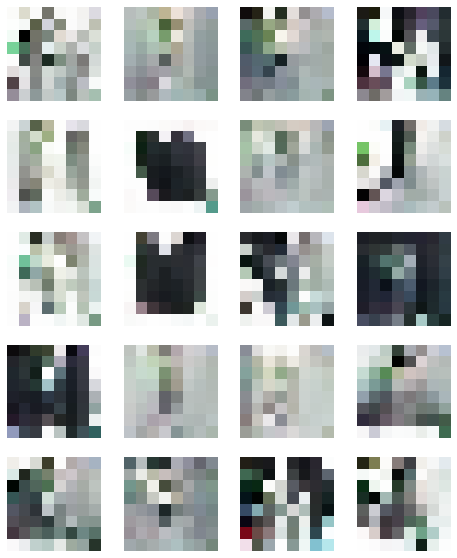

Found 83205 files belonging to 1 classes.
Batch: 6525 / 15625
Alpha: 1.0
D Loss: R: -4.396476 F: 4.557037 GP: 0.236168
G Loss: -4.083042
Batch: 6550 / 15625
Alpha: 1.0
D Loss: R: -5.218565 F: 5.427906 GP: 0.149523
G Loss: -5.704541
Batch: 6575 / 15625
Alpha: 1.0
D Loss: R: -4.273548 F: 4.496641 GP: 0.155471
G Loss: -4.670720
Batch: 6600 / 15625
Alpha: 1.0
D Loss: R: -4.720463 F: 4.855375 GP: 0.627267
G Loss: -2.964904
Batch: 6625 / 15625
Alpha: 1.0
D Loss: R: -3.387267 F: 3.367042 GP: 0.141568
G Loss: -3.187567
Batch: 6650 / 15625
Alpha: 1.0
D Loss: R: -4.597825 F: 4.679855 GP: 0.130299
G Loss: -4.323048
Batch: 6675 / 15625
Alpha: 1.0
D Loss: R: -3.912945 F: 3.968095 GP: 0.397377
G Loss: -4.566689
Batch: 6700 / 15625
Alpha: 1.0
D Loss: R: -4.148157 F: 4.209497 GP: 0.214942
G Loss: -4.330780
Batch: 6725 / 15625
Alpha: 1.0
D Loss: R: -3.491564 F: 3.562717 GP: 0.198723
G Loss: -3.907649
Batch: 6750 / 15625
Alpha: 1.0
D Loss: R: -3.572144 F: 3.597039 GP: 0.199872
G Loss: -3.182856
Batch: 6

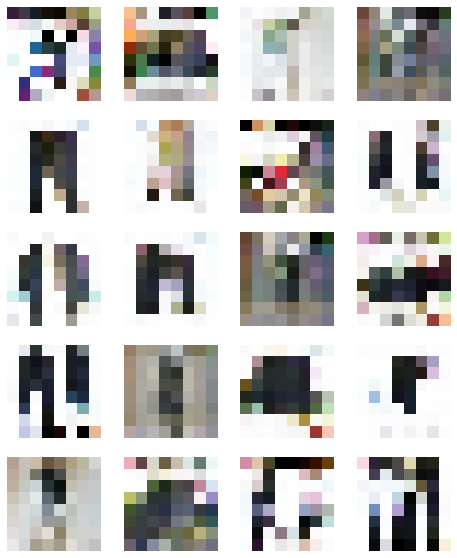

Batch: 7025 / 15625
Alpha: 1.0
D Loss: R: -1.881705 F: 1.961176 GP: 0.074624
G Loss: -2.118878
Batch: 7050 / 15625
Alpha: 1.0
D Loss: R: -2.359919 F: 2.458841 GP: 0.215258
G Loss: -0.831822
Batch: 7075 / 15625
Alpha: 1.0
D Loss: R: -2.523072 F: 2.543434 GP: 0.054081
G Loss: -2.116387
Batch: 7100 / 15625
Alpha: 1.0
D Loss: R: -1.794833 F: 1.818460 GP: 0.074296
G Loss: -1.520479
Batch: 7125 / 15625
Alpha: 1.0
D Loss: R: -0.984846 F: 1.033380 GP: 0.075240
G Loss: -0.491909
Batch: 7150 / 15625
Alpha: 1.0
D Loss: R: -1.633267 F: 1.698525 GP: 0.483634
G Loss: -2.037905
Found 83205 files belonging to 1 classes.
Batch: 7175 / 15625
Alpha: 1.0
D Loss: R: -0.673679 F: 0.705641 GP: 0.229973
G Loss: -0.610160
Batch: 7200 / 15625
Alpha: 1.0
D Loss: R: -0.691528 F: 0.798355 GP: 0.208950
G Loss: -1.410027
Batch: 7225 / 15625
Alpha: 1.0
D Loss: R: -3.919683 F: 3.899424 GP: 0.144457
G Loss: -2.897104
Batch: 7250 / 15625
Alpha: 1.0
D Loss: R: -2.182046 F: 2.176793 GP: 0.074393
G Loss: -2.196399
Batch: 7

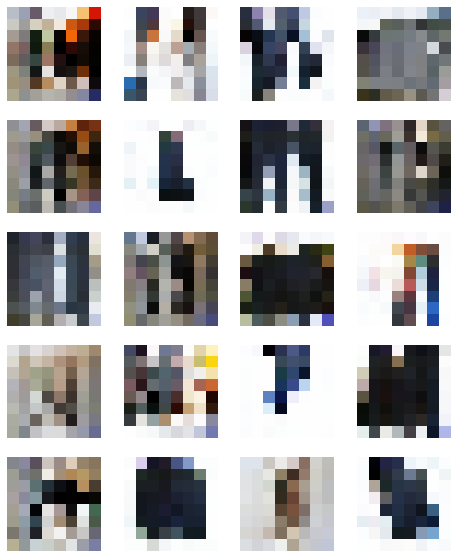

Batch: 7525 / 15625
Alpha: 1.0
D Loss: R: -6.687635 F: 6.760654 GP: 0.057283
G Loss: -6.489323
Batch: 7550 / 15625
Alpha: 1.0
D Loss: R: -7.663200 F: 7.866549 GP: 0.485595
G Loss: -5.487392
Batch: 7575 / 15625
Alpha: 1.0
D Loss: R: -6.666027 F: 6.870804 GP: 0.077457
G Loss: -6.717769
Batch: 7600 / 15625
Alpha: 1.0
D Loss: R: -6.221547 F: 6.274444 GP: 0.075750
G Loss: -6.843361
Batch: 7625 / 15625
Alpha: 1.0
D Loss: R: -6.012307 F: 6.014830 GP: 0.069560
G Loss: -5.765113
Batch: 7650 / 15625
Alpha: 1.0
D Loss: R: -6.841466 F: 6.819360 GP: 0.263070
G Loss: -7.430544
Batch: 7675 / 15625
Alpha: 1.0
D Loss: R: -4.766185 F: 4.694844 GP: 0.177210
G Loss: -3.804881
Batch: 7700 / 15625
Alpha: 1.0
D Loss: R: -5.258260 F: 5.211692 GP: 0.044744
G Loss: -5.408519
Batch: 7725 / 15625
Alpha: 1.0
D Loss: R: -5.765945 F: 5.750987 GP: 0.116062
G Loss: -5.915114
Batch: 7750 / 15625
Alpha: 1.0
D Loss: R: -6.438723 F: 6.512336 GP: 0.242191
G Loss: -5.099149
Batch: 7775 / 15625
Alpha: 1.0
D Loss: R: -6.90900

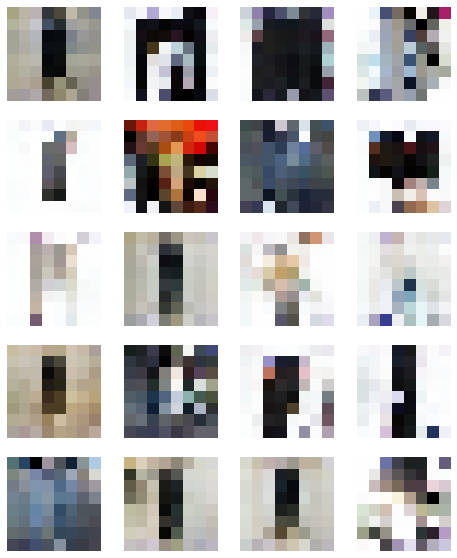

Batch: 8025 / 15625
Alpha: 1.0
D Loss: R: -9.089168 F: 9.068001 GP: 0.224837
G Loss: -8.751858
Batch: 8050 / 15625
Alpha: 1.0
D Loss: R: -8.902475 F: 8.876587 GP: 0.090745
G Loss: -8.938391
Batch: 8075 / 15625
Alpha: 1.0
D Loss: R: -9.657318 F: 9.667502 GP: 0.097930
G Loss: -9.735826
Batch: 8100 / 15625
Alpha: 1.0
D Loss: R: -9.270343 F: 9.358965 GP: 0.089053
G Loss: -9.305298
Batch: 8125 / 15625
Alpha: 1.0
D Loss: R: -10.198739 F: 10.195581 GP: 0.401507
G Loss: -10.632711
Batch: 8150 / 15625
Alpha: 1.0
D Loss: R: -9.679420 F: 9.663382 GP: 0.094115
G Loss: -9.744752
Batch: 8175 / 15625
Alpha: 1.0
D Loss: R: -11.304984 F: 11.358837 GP: 0.097783
G Loss: -9.224297
Batch: 8200 / 15625
Alpha: 1.0
D Loss: R: -10.686815 F: 10.658842 GP: 0.196343
G Loss: -10.439232
Batch: 8225 / 15625
Alpha: 1.0
D Loss: R: -8.768635 F: 8.735669 GP: 0.126201
G Loss: -9.051619
Batch: 8250 / 15625
Alpha: 1.0
D Loss: R: -10.496530 F: 10.389915 GP: 0.091906
G Loss: -10.143744
Batch: 8275 / 15625
Alpha: 1.0
D Loss: 

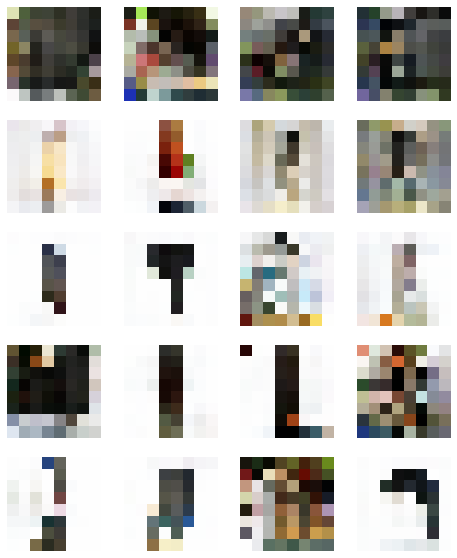

Batch: 8525 / 15625
Alpha: 1.0
D Loss: R: -7.070695 F: 7.038610 GP: 0.090042
G Loss: -6.988247
Batch: 8550 / 15625
Alpha: 1.0
D Loss: R: -8.487861 F: 8.408670 GP: 0.144808
G Loss: -9.490808
Batch: 8575 / 15625
Alpha: 1.0
D Loss: R: -7.911424 F: 7.863096 GP: 0.093981
G Loss: -7.716406
Batch: 8600 / 15625
Alpha: 1.0
D Loss: R: -9.014688 F: 8.967960 GP: 0.132081
G Loss: -8.258299
Batch: 8625 / 15625
Alpha: 1.0
D Loss: R: -7.911118 F: 7.833008 GP: 0.071958
G Loss: -7.209682
Batch: 8650 / 15625
Alpha: 1.0
D Loss: R: -6.918789 F: 6.808231 GP: 0.062039
G Loss: -6.737213
Batch: 8675 / 15625
Alpha: 1.0
D Loss: R: -7.255017 F: 7.147767 GP: 0.078153
G Loss: -6.946831
Batch: 8700 / 15625
Alpha: 1.0
D Loss: R: -6.794806 F: 6.776916 GP: 0.101538
G Loss: -6.439971
Batch: 8725 / 15625
Alpha: 1.0
D Loss: R: -6.713145 F: 6.618248 GP: 0.081207
G Loss: -6.247684
Batch: 8750 / 15625
Alpha: 1.0
D Loss: R: -6.839004 F: 6.723956 GP: 0.120968
G Loss: -6.539712
Batch: 8775 / 15625
Alpha: 1.0
D Loss: R: -6.74639

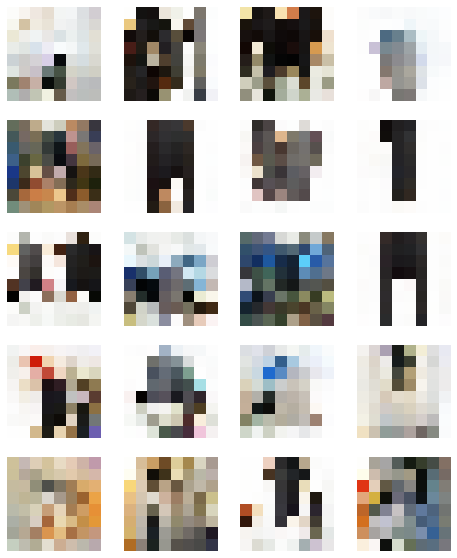

Batch: 9025 / 15625
Alpha: 1.0
D Loss: R: -5.473132 F: 5.403126 GP: 0.076903
G Loss: -5.502467
Batch: 9050 / 15625
Alpha: 1.0
D Loss: R: -5.923984 F: 5.899988 GP: 0.105759
G Loss: -6.054030
Batch: 9075 / 15625
Alpha: 1.0
D Loss: R: -5.845116 F: 5.739150 GP: 0.110886
G Loss: -5.919732
Batch: 9100 / 15625
Alpha: 1.0
D Loss: R: -4.469703 F: 4.381210 GP: 0.071702
G Loss: -4.394747
Found 83205 files belonging to 1 classes.
Batch: 9125 / 15625
Alpha: 1.0
D Loss: R: -4.986991 F: 4.922794 GP: 0.089554
G Loss: -4.855095
Batch: 9150 / 15625
Alpha: 1.0
D Loss: R: -5.135201 F: 5.085947 GP: 0.085114
G Loss: -5.092686
Batch: 9175 / 15625
Alpha: 1.0
D Loss: R: -5.350803 F: 5.274766 GP: 0.106380
G Loss: -5.426067
Batch: 9200 / 15625
Alpha: 1.0
D Loss: R: -5.430810 F: 5.297258 GP: 0.088859
G Loss: -5.015063
Batch: 9225 / 15625
Alpha: 1.0
D Loss: R: -5.182261 F: 5.141495 GP: 0.102606
G Loss: -4.830656
Batch: 9250 / 15625
Alpha: 1.0
D Loss: R: -5.186250 F: 5.033601 GP: 0.060699
G Loss: -5.523858
Batch: 9

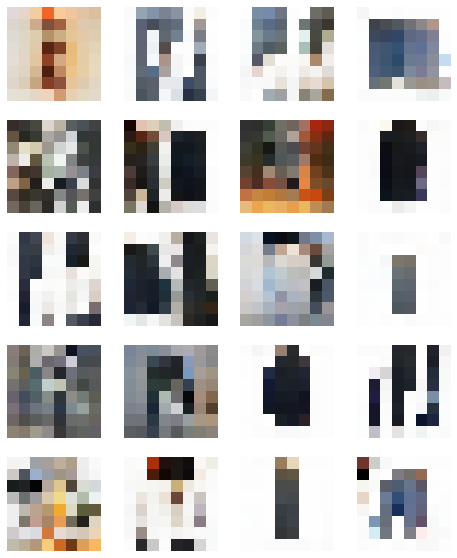

Batch: 9525 / 15625
Alpha: 1.0
D Loss: R: -5.301118 F: 5.122934 GP: 0.063803
G Loss: -5.097652
Batch: 9550 / 15625
Alpha: 1.0
D Loss: R: -4.125030 F: 3.884425 GP: 0.145894
G Loss: -4.791623
Batch: 9575 / 15625
Alpha: 1.0
D Loss: R: -4.900083 F: 4.826950 GP: 0.074879
G Loss: -4.600328
Batch: 9600 / 15625
Alpha: 1.0
D Loss: R: -5.016373 F: 4.854602 GP: 0.137656
G Loss: -5.084265
Batch: 9625 / 15625
Alpha: 1.0
D Loss: R: -5.107987 F: 5.033734 GP: 0.109262
G Loss: -4.543876
Batch: 9650 / 15625
Alpha: 1.0
D Loss: R: -4.720923 F: 4.601884 GP: 0.055889
G Loss: -4.334270
Batch: 9675 / 15625
Alpha: 1.0
D Loss: R: -4.669695 F: 4.562019 GP: 0.074681
G Loss: -4.718855
Batch: 9700 / 15625
Alpha: 1.0
D Loss: R: -4.392640 F: 4.320494 GP: 0.171216
G Loss: -4.121078
Batch: 9725 / 15625
Alpha: 1.0
D Loss: R: -4.643335 F: 4.535535 GP: 0.107362
G Loss: -4.781975
Batch: 9750 / 15625
Alpha: 1.0
D Loss: R: -4.836460 F: 4.689819 GP: 0.066192
G Loss: -4.818818
Found 83205 files belonging to 1 classes.
Batch: 9

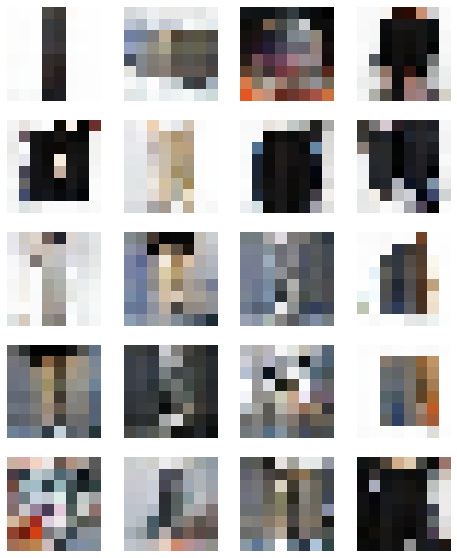

Batch: 10025 / 15625
Alpha: 1.0
D Loss: R: -4.675915 F: 4.545856 GP: 0.084924
G Loss: -4.672752
Batch: 10050 / 15625
Alpha: 1.0
D Loss: R: -5.143081 F: 5.175831 GP: 0.085258
G Loss: -4.493779
Batch: 10075 / 15625
Alpha: 1.0
D Loss: R: -4.585846 F: 4.361667 GP: 0.095097
G Loss: -4.584888
Batch: 10100 / 15625
Alpha: 1.0
D Loss: R: -4.648890 F: 4.546912 GP: 0.064796
G Loss: -4.766262
Batch: 10125 / 15625
Alpha: 1.0
D Loss: R: -4.849340 F: 4.626934 GP: 0.107376
G Loss: -4.506061
Batch: 10150 / 15625
Alpha: 1.0
D Loss: R: -4.540135 F: 4.396237 GP: 0.077428
G Loss: -4.397898
Batch: 10175 / 15625
Alpha: 1.0
D Loss: R: -4.654460 F: 4.570354 GP: 0.107443
G Loss: -4.448061
Batch: 10200 / 15625
Alpha: 1.0
D Loss: R: -3.961870 F: 3.810477 GP: 0.098807
G Loss: -3.440224
Batch: 10225 / 15625
Alpha: 1.0
D Loss: R: -4.107433 F: 4.018778 GP: 0.063376
G Loss: -3.969426
Batch: 10250 / 15625
Alpha: 1.0
D Loss: R: -4.881102 F: 4.681717 GP: 0.089753
G Loss: -4.218134
Batch: 10275 / 15625
Alpha: 1.0
D Loss: 

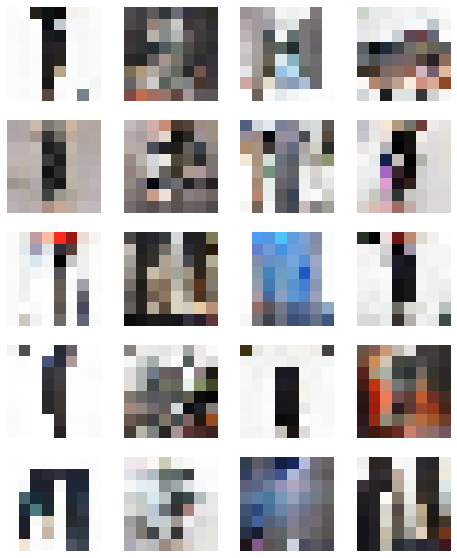

Batch: 10525 / 15625
Alpha: 1.0
D Loss: R: -3.936327 F: 3.690197 GP: 0.083408
G Loss: -3.823664
Batch: 10550 / 15625
Alpha: 1.0
D Loss: R: -4.281487 F: 4.144119 GP: 0.066932
G Loss: -4.117322
Batch: 10575 / 15625
Alpha: 1.0
D Loss: R: -4.093961 F: 3.924748 GP: 0.087040
G Loss: -3.966393
Batch: 10600 / 15625
Alpha: 1.0
D Loss: R: -4.342083 F: 4.276248 GP: 0.112247
G Loss: -3.847822
Batch: 10625 / 15625
Alpha: 1.0
D Loss: R: -4.176755 F: 4.115088 GP: 0.080558
G Loss: -3.901651
Batch: 10650 / 15625
Alpha: 1.0
D Loss: R: -4.461555 F: 4.342146 GP: 0.064735
G Loss: -4.620357
Batch: 10675 / 15625
Alpha: 1.0
D Loss: R: -3.854342 F: 3.840721 GP: 0.090101
G Loss: -3.666430
Batch: 10700 / 15625
Alpha: 1.0
D Loss: R: -3.457173 F: 3.484311 GP: 0.225929
G Loss: -4.110967


KeyboardInterrupt: ignored

In [ ]:
train_progan(gan, 8,
             checkpoint_path=base_dir+'8x8/',
             transition_kimg=600,
             total_ki
             mg=2000)

1. 학습 Model 설정 
- 어떤 모델을 할지 (시계열 학습을 할지 , 이미지 학습 , 텍스트 ) 적어도 2개 이상의 모델을 설정 (권장 모델은 3개)
- 모델의 초기설정(network 설정) 을 layer를 몇개 할지 , state 를 몇개할지 => 데이터를 잃지 않는 최소한의 기본 설정으로 할것
- 활성화함수(relu , softmax , sigmoid) 선택 
- 수렴조건 ==> 모델 검증 




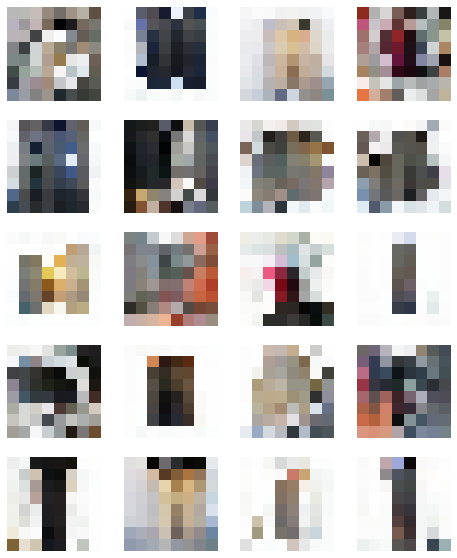

In [ ]:
gan.load(8, base_dir+'8x8/')
K.set_value(gan.alpha_G, 1.0)
plot_generated_images(gan, 8, latents_in=latents_test)

Found 83205 files belonging to 1 classes.


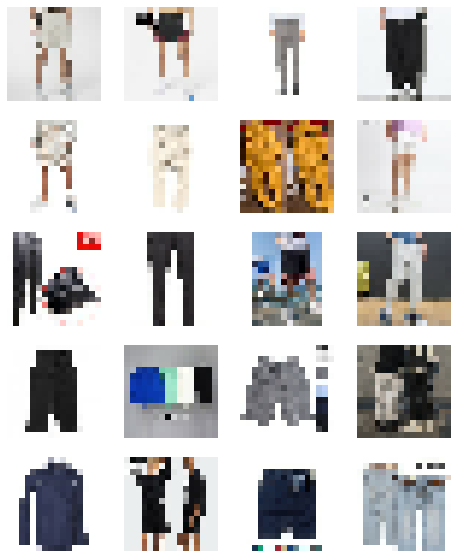

In [ ]:
plot_real_images(16)

In [ ]:
gan = ProGAN()

In [ ]:
gan.load(8, base_dir+'8x8/')
gan.transfer_previous_resolution_weights(16)

Copied 26746884 parameters to the higher resolution model.


Found 83205 files belonging to 1 classes.
Batch: 25 / 15625
Alpha: 0.005333333333333333
D Loss: R: -31.241890 F: 26.696316 GP: 2.563047
G Loss: -25.325703
Batch: 50 / 15625
Alpha: 0.010666666666666666
D Loss: R: -23.184155 F: 17.129597 GP: 1.108677
G Loss: -13.025120
Batch: 75 / 15625
Alpha: 0.016
D Loss: R: -25.762598 F: 18.117435 GP: 1.492449
G Loss: -16.068970
Batch: 100 / 15625
Alpha: 0.021333333333333333
D Loss: R: -28.874168 F: 18.869291 GP: 3.150557
G Loss: -19.362413
Batch: 125 / 15625
Alpha: 0.02666666666666667
D Loss: R: -28.056381 F: 17.691399 GP: 3.328419
G Loss: -21.390427
Batch: 150 / 15625
Alpha: 0.032
D Loss: R: -24.975143 F: 15.469585 GP: 2.561016
G Loss: -29.348362
Batch: 175 / 15625
Alpha: 0.037333333333333336
D Loss: R: -32.079575 F: 24.168175 GP: 1.201693
G Loss: -28.752031
Batch: 200 / 15625
Alpha: 0.042666666666666665
D Loss: R: -28.580704 F: 18.037975 GP: 3.458609
G Loss: -14.915791
Batch: 225 / 15625
Alpha: 0.048
D Loss: R: -29.168680 F: 20.769547 GP: 1.684606


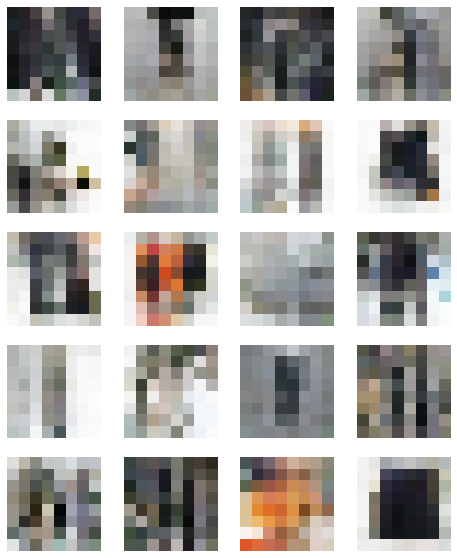

Batch: 525 / 15625
Alpha: 0.112
D Loss: R: -25.244007 F: 16.802025 GP: 2.898656
G Loss: -17.452826
Batch: 550 / 15625
Alpha: 0.11733333333333333
D Loss: R: -20.948616 F: 10.363736 GP: 2.163306
G Loss: -13.654135
Batch: 575 / 15625
Alpha: 0.12266666666666666
D Loss: R: -20.880861 F: 10.158602 GP: 4.856887
G Loss: -15.020027
Batch: 600 / 15625
Alpha: 0.128
D Loss: R: -19.414154 F: 13.554588 GP: 0.602645
G Loss: -10.633819
Batch: 625 / 15625
Alpha: 0.13333333333333333
D Loss: R: -19.982008 F: 10.811590 GP: 1.583182
G Loss: -14.685579
Batch: 650 / 15625
Alpha: 0.13866666666666666
D Loss: R: -21.693512 F: 13.995586 GP: 0.827385
G Loss: -11.350275
Found 83205 files belonging to 1 classes.
Batch: 675 / 15625
Alpha: 0.144
D Loss: R: -18.393139 F: 11.594127 GP: 0.720176
G Loss: -9.971422
Batch: 700 / 15625
Alpha: 0.14933333333333335
D Loss: R: -22.281130 F: 11.611582 GP: 2.610954
G Loss: -14.915335
Batch: 725 / 15625
Alpha: 0.15466666666666667
D Loss: R: -22.387623 F: 12.472558 GP: 1.834287
G L

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Done.


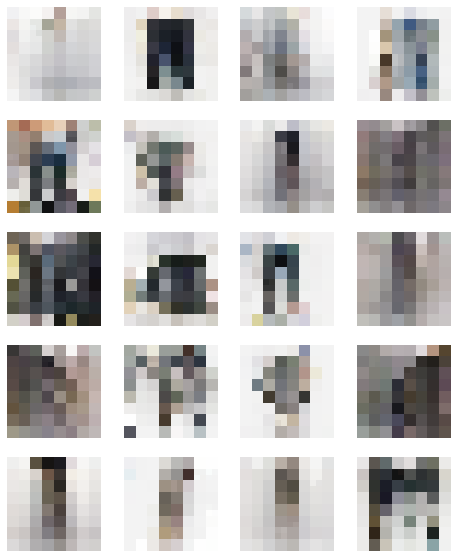

Batch: 1025 / 15625
Alpha: 0.21866666666666668
D Loss: R: -19.521042 F: 11.090725 GP: 2.194289
G Loss: -10.837114
Batch: 1050 / 15625
Alpha: 0.224
D Loss: R: -14.132071 F: 10.395420 GP: 0.961891
G Loss: -10.580157
Batch: 1075 / 15625
Alpha: 0.22933333333333333
D Loss: R: 10.750275 F: -17.436369 GP: 1.270950
G Loss: 9.946468
Batch: 1100 / 15625
Alpha: 0.23466666666666666
D Loss: R: 5.294240 F: -10.951834 GP: 0.770022
G Loss: 13.264185
Batch: 1125 / 15625
Alpha: 0.24
D Loss: R: 8.427152 F: -13.298040 GP: 0.410499
G Loss: 12.821312
Batch: 1150 / 15625
Alpha: 0.24533333333333332
D Loss: R: 1.616034 F: -8.631074 GP: 0.821157
G Loss: 9.580932
Batch: 1175 / 15625
Alpha: 0.25066666666666665
D Loss: R: 0.383891 F: -7.305373 GP: 1.144969
G Loss: 9.474354
Batch: 1200 / 15625
Alpha: 0.256
D Loss: R: 1.612664 F: -8.973636 GP: 0.804366
G Loss: 8.535213
Batch: 1225 / 15625
Alpha: 0.2613333333333333
D Loss: R: 0.981231 F: -6.275308 GP: 0.162829
G Loss: 5.650915
Batch: 1250 / 15625
Alpha: 0.26666666666

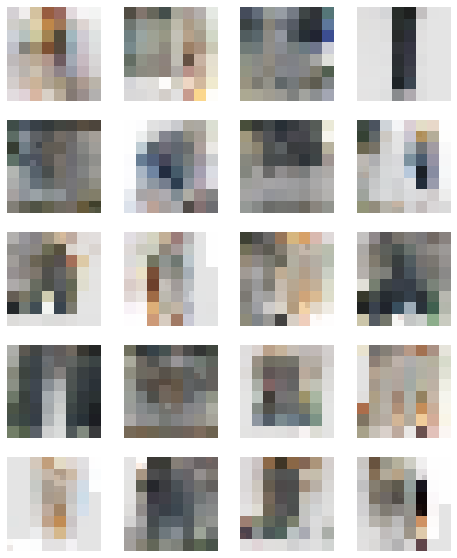

Batch: 1525 / 15625
Alpha: 0.3253333333333333
D Loss: R: -6.185332 F: -0.129580 GP: 1.720898
G Loss: 0.647353
Batch: 1550 / 15625
Alpha: 0.33066666666666666
D Loss: R: -5.815194 F: -0.207472 GP: 0.712259
G Loss: 0.091245
Batch: 1575 / 15625
Alpha: 0.336
D Loss: R: -4.976487 F: -0.694556 GP: 0.820105
G Loss: 0.711272
Batch: 1600 / 15625
Alpha: 0.3413333333333333
D Loss: R: -5.248888 F: -0.969034 GP: 1.312451
G Loss: 2.178610
Batch: 1625 / 15625
Alpha: 0.3466666666666667
D Loss: R: -5.755660 F: 0.292844 GP: 0.995371
G Loss: 0.913970
Batch: 1650 / 15625
Alpha: 0.352
D Loss: R: -6.463453 F: -0.025336 GP: 1.528015
G Loss: 1.254338
Batch: 1675 / 15625
Alpha: 0.35733333333333334
D Loss: R: -4.476032 F: -0.955605 GP: 1.053011
G Loss: 1.245497
Batch: 1700 / 15625
Alpha: 0.3626666666666667
D Loss: R: -6.852159 F: 1.568313 GP: 1.586841
G Loss: -0.780663
Batch: 1725 / 15625
Alpha: 0.368
D Loss: R: -6.030380 F: 2.424922 GP: 1.353846
G Loss: 1.056950
Batch: 1750 / 15625
Alpha: 0.37333333333333335
D 

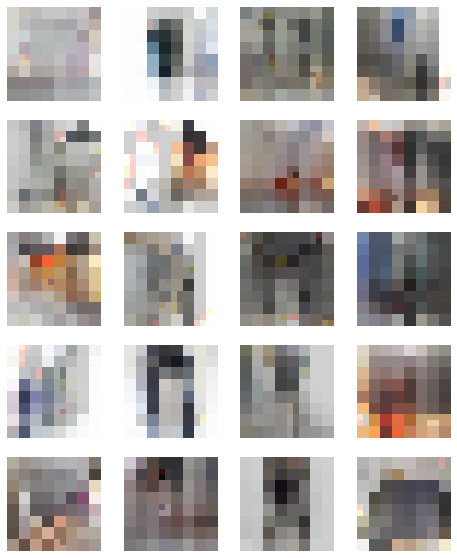

Batch: 2025 / 15625
Alpha: 0.432
D Loss: R: -2.166348 F: -1.101111 GP: 0.308763
G Loss: -0.259568
Batch: 2050 / 15625
Alpha: 0.43733333333333335
D Loss: R: -2.002553 F: -1.186038 GP: 0.413813
G Loss: -0.013199
Batch: 2075 / 15625
Alpha: 0.44266666666666665
D Loss: R: -4.790400 F: 0.888531 GP: 0.508286
G Loss: 0.561628
Batch: 2100 / 15625
Alpha: 0.448
D Loss: R: -2.280219 F: -1.536279 GP: 0.566650
G Loss: 0.756362
Batch: 2125 / 15625
Alpha: 0.4533333333333333
D Loss: R: -4.265620 F: 0.717239 GP: 1.324447
G Loss: 1.219666
Batch: 2150 / 15625
Alpha: 0.45866666666666667
D Loss: R: -3.561300 F: -0.360334 GP: 1.450295
G Loss: 1.367970
Batch: 2175 / 15625
Alpha: 0.464
D Loss: R: -2.040007 F: -1.535621 GP: 0.633836
G Loss: 0.242942
Batch: 2200 / 15625
Alpha: 0.4693333333333333
D Loss: R: -5.624558 F: 1.842342 GP: 1.867350
G Loss: 1.616914
Batch: 2225 / 15625
Alpha: 0.4746666666666667
D Loss: R: -3.144680 F: 0.095953 GP: 0.457070
G Loss: -0.699728
Batch: 2250 / 15625
Alpha: 0.48
D Loss: R: -3.3

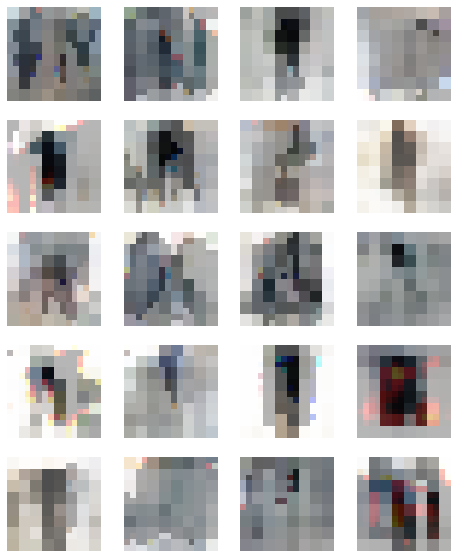

Batch: 2525 / 15625
Alpha: 0.5386666666666666
D Loss: R: -2.158479 F: -0.453325 GP: 0.386946
G Loss: 1.799725
Batch: 2550 / 15625
Alpha: 0.544
D Loss: R: -3.952402 F: 1.311383 GP: 0.194361
G Loss: -0.081005
Batch: 2575 / 15625
Alpha: 0.5493333333333333
D Loss: R: -4.511226 F: 0.528082 GP: 1.315940
G Loss: -0.660848
Batch: 2600 / 15625
Alpha: 0.5546666666666666
D Loss: R: -1.701647 F: -0.268937 GP: 0.302225
G Loss: 0.148158
Found 83205 files belonging to 1 classes.
Batch: 2625 / 15625
Alpha: 0.56
D Loss: R: -3.719229 F: 0.574004 GP: 0.563852
G Loss: -0.958369
Batch: 2650 / 15625
Alpha: 0.5653333333333334
D Loss: R: -3.920796 F: 1.094612 GP: 0.583060
G Loss: -1.116002
Batch: 2675 / 15625
Alpha: 0.5706666666666667
D Loss: R: -2.522491 F: 0.555985 GP: 0.469767
G Loss: -0.216508
Batch: 2700 / 15625
Alpha: 0.576
D Loss: R: -4.154202 F: 1.604574 GP: 0.299923
G Loss: -2.216524
Batch: 2725 / 15625
Alpha: 0.5813333333333334
D Loss: R: -3.085551 F: 0.714323 GP: 0.207546
G Loss: -0.899406
Batch: 2

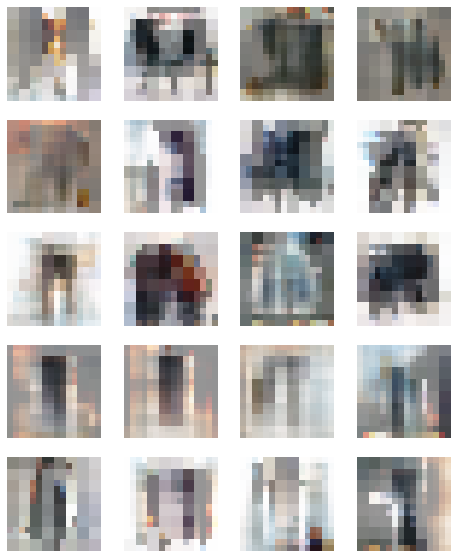

Batch: 3025 / 15625
Alpha: 0.6453333333333333
D Loss: R: -5.008263 F: 2.380472 GP: 0.573987
G Loss: -1.417451
Batch: 3050 / 15625
Alpha: 0.6506666666666666
D Loss: R: -4.654929 F: 2.638067 GP: 0.508402
G Loss: -3.240030
Batch: 3075 / 15625
Alpha: 0.656
D Loss: R: -3.858295 F: 2.524817 GP: 0.480729
G Loss: -2.691970
Batch: 3100 / 15625
Alpha: 0.6613333333333333
D Loss: R: -3.837229 F: 2.137286 GP: 0.247098
G Loss: -2.352288
Batch: 3125 / 15625
Alpha: 0.6666666666666666
D Loss: R: -2.414858 F: 1.247196 GP: 0.225306
G Loss: -1.571176
Batch: 3150 / 15625
Alpha: 0.672
D Loss: R: -3.802814 F: 1.939393 GP: 0.184407
G Loss: -2.245400
Batch: 3175 / 15625
Alpha: 0.6773333333333333
D Loss: R: -3.520606 F: 2.050863 GP: 0.839461
G Loss: -1.431886
Batch: 3200 / 15625
Alpha: 0.6826666666666666
D Loss: R: -2.538138 F: 0.855628 GP: 0.256229
G Loss: -0.617693
Batch: 3225 / 15625
Alpha: 0.688
D Loss: R: -3.541121 F: 1.816661 GP: 0.308499
G Loss: -3.018251
Batch: 3250 / 15625
Alpha: 0.6933333333333334
D L

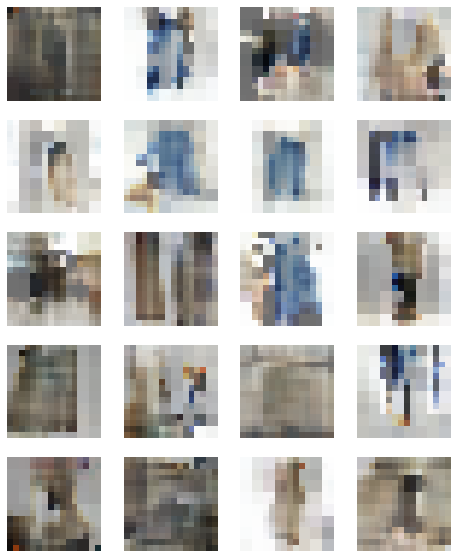

Batch: 3525 / 15625
Alpha: 0.752
D Loss: R: -2.691998 F: 1.361439 GP: 0.298826
G Loss: -0.491977
Batch: 3550 / 15625
Alpha: 0.7573333333333333
D Loss: R: 0.708225 F: -1.878343 GP: 0.234291
G Loss: 0.435515
Batch: 3575 / 15625
Alpha: 0.7626666666666667
D Loss: R: 0.295731 F: -1.149467 GP: 0.595466
G Loss: 2.429235
Batch: 3600 / 15625
Alpha: 0.768
D Loss: R: -1.761097 F: 0.572044 GP: 0.609563
G Loss: -0.195413
Batch: 3625 / 15625
Alpha: 0.7733333333333333
D Loss: R: 0.729805 F: -2.077406 GP: 0.268238
G Loss: 1.143346
Batch: 3650 / 15625
Alpha: 0.7786666666666666
D Loss: R: -0.411907 F: -0.676029 GP: 0.260703
G Loss: 0.864309
Batch: 3675 / 15625
Alpha: 0.784
D Loss: R: 0.800107 F: -1.892202 GP: 0.279246
G Loss: 1.994239
Batch: 3700 / 15625
Alpha: 0.7893333333333333
D Loss: R: 0.730036 F: -2.241431 GP: 0.249997
G Loss: 1.385026
Batch: 3725 / 15625
Alpha: 0.7946666666666666
D Loss: R: -1.558809 F: 0.599215 GP: 0.261037
G Loss: 1.508319
Batch: 3750 / 15625
Alpha: 0.8
D Loss: R: -0.990381 F: 

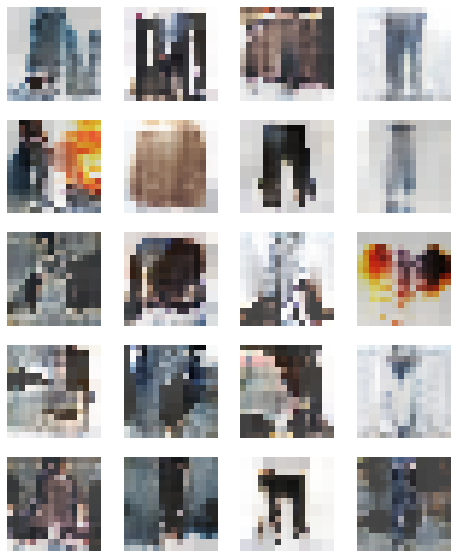

Batch: 4025 / 15625
Alpha: 0.8586666666666667
D Loss: R: 0.820206 F: -1.399935 GP: 0.290084
G Loss: 0.643154


KeyboardInterrupt: ignored

In [ ]:
train_progan(gan, 16,
             checkpoint_path=base_dir+'16x16/',
             transition_kimg=600,
             total_kimg=2000)

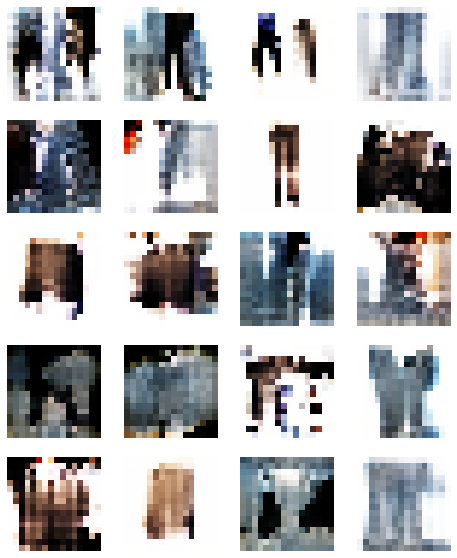

In [ ]:
gan.load(16, base_dir+'16x16/')
K.set_value(gan.alpha_G, 1.0)
plot_generated_images(gan, 16, latents_in=latents_test)

Found 83205 files belonging to 1 classes.


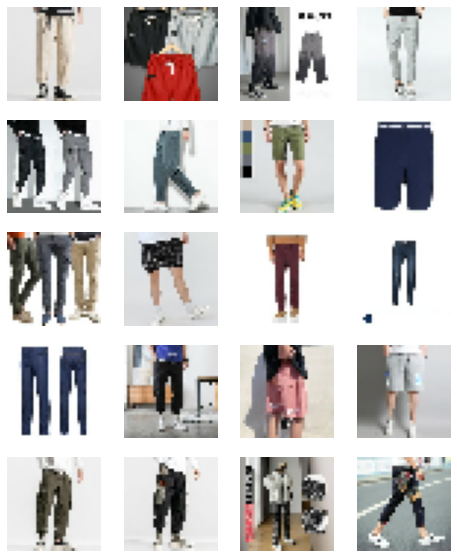

In [ ]:
plot_real_images(32)

In [ ]:
gan = ProGAN(batch_size=32)

In [ ]:
gan.load(16, base_dir+'16x16/')
gan.transfer_previous_resolution_weights(32)

Copied 36186116 parameters to the higher resolution model.


class ProGAN 에서 32x32를 진행할때는 batch_size를 32로 변경해야함 
why? GPU에 대한 메모리가 부족하다고 에러발생 ( batch_size를 64 => 32 했을 때 에러 해결)

Found 83205 files belonging to 1 classes.
Batch: 25 / 62500
Alpha: 0.0013333333333333333
D Loss: R: -0.655896 F: -3.371891 GP: 7.930956
G Loss: 1.927160
Batch: 50 / 62500
Alpha: 0.0026666666666666666
D Loss: R: -32.858757 F: 22.296947 GP: 1.017050
G Loss: -9.585330
Batch: 75 / 62500
Alpha: 0.004
D Loss: R: -62.512222 F: 48.102615 GP: 2.118551
G Loss: -67.385864
Batch: 100 / 62500
Alpha: 0.005333333333333333
D Loss: R: -39.060181 F: 16.705765 GP: 2.538585
G Loss: -12.377987
Batch: 125 / 62500
Alpha: 0.006666666666666667
D Loss: R: -52.100590 F: 35.395752 GP: 3.065787
G Loss: -13.195353
Batch: 150 / 62500
Alpha: 0.008
D Loss: R: -20.529301 F: -3.465932 GP: 5.264349
G Loss: -10.824062
Batch: 175 / 62500
Alpha: 0.009333333333333334
D Loss: R: -36.819473 F: 13.294756 GP: 3.969517
G Loss: 1.608718
Batch: 200 / 62500
Alpha: 0.010666666666666666
D Loss: R: -7.999984 F: -11.708920 GP: 1.164094
G Loss: 33.140480
Batch: 225 / 62500
Alpha: 0.012
D Loss: R: -5.818941 F: -7.373195 GP: 0.706544
G Los

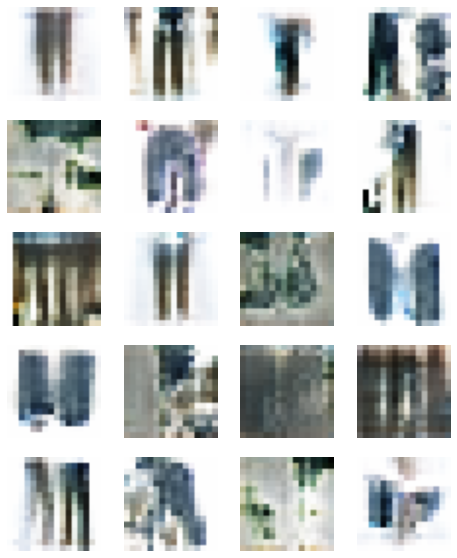

Batch: 525 / 62500
Alpha: 0.028
D Loss: R: -4.337347 F: -27.763340 GP: 9.610556
G Loss: 10.878811
Batch: 550 / 62500
Alpha: 0.029333333333333333
D Loss: R: -21.014637 F: -16.553051 GP: 8.155294
G Loss: -1.424236
Batch: 575 / 62500
Alpha: 0.030666666666666665
D Loss: R: -23.511312 F: -6.481438 GP: 5.914032
G Loss: -3.487396
Batch: 600 / 62500
Alpha: 0.032
D Loss: R: -17.921354 F: -16.180122 GP: 6.631933
G Loss: -4.633101
Batch: 625 / 62500
Alpha: 0.03333333333333333
D Loss: R: -1.705155 F: -8.669133 GP: 1.603636
G Loss: 28.509781
Batch: 650 / 62500
Alpha: 0.034666666666666665
D Loss: R: -29.571243 F: -5.188324 GP: 7.424856
G Loss: 0.126071
Batch: 675 / 62500
Alpha: 0.036
D Loss: R: -29.192650 F: -0.075194 GP: 10.634408
G Loss: 21.039921
Batch: 700 / 62500
Alpha: 0.037333333333333336
D Loss: R: -15.944172 F: -12.281609 GP: 5.031804
G Loss: -9.839703
Batch: 725 / 62500
Alpha: 0.03866666666666667
D Loss: R: -29.526226 F: -7.394425 GP: 10.288275
G Loss: 26.608135
Batch: 750 / 62500
Alpha: 0

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Done.


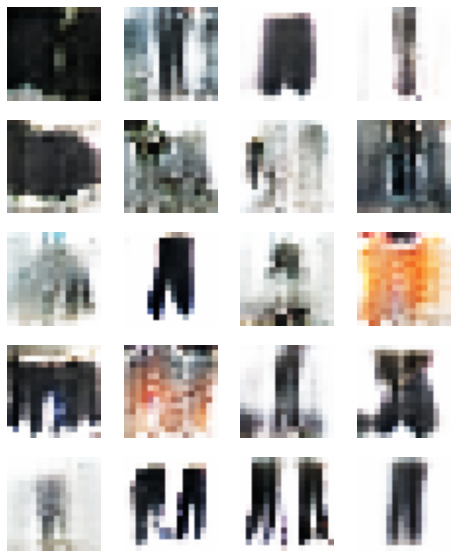

Batch: 1025 / 62500
Alpha: 0.05466666666666667
D Loss: R: -26.490314 F: -8.738894 GP: 11.478027
G Loss: -4.821051
Batch: 1050 / 62500
Alpha: 0.056
D Loss: R: -52.860413 F: 51.246284 GP: 2.122548
G Loss: -0.927645
Batch: 1075 / 62500
Alpha: 0.05733333333333333
D Loss: R: 10.085594 F: -38.015556 GP: 5.410452
G Loss: 31.153316
Batch: 1100 / 62500
Alpha: 0.058666666666666666
D Loss: R: -24.199013 F: -11.191852 GP: 6.543884
G Loss: 11.930408
Batch: 1125 / 62500
Alpha: 0.06
D Loss: R: -50.613205 F: 20.084337 GP: 9.669405
G Loss: 10.511264
Batch: 1150 / 62500
Alpha: 0.06133333333333333
D Loss: R: -16.056051 F: -9.035383 GP: 7.925100
G Loss: 2.689990
Batch: 1175 / 62500
Alpha: 0.06266666666666666
D Loss: R: -43.856918 F: 0.163668 GP: 10.465435
G Loss: 1.222569
Batch: 1200 / 62500
Alpha: 0.064
D Loss: R: -25.681190 F: -3.476964 GP: 3.103293
G Loss: 4.918650
Batch: 1225 / 62500
Alpha: 0.06533333333333333
D Loss: R: 3.135464 F: -36.240128 GP: 10.578024
G Loss: 24.931583
Batch: 1250 / 62500
Alpha:

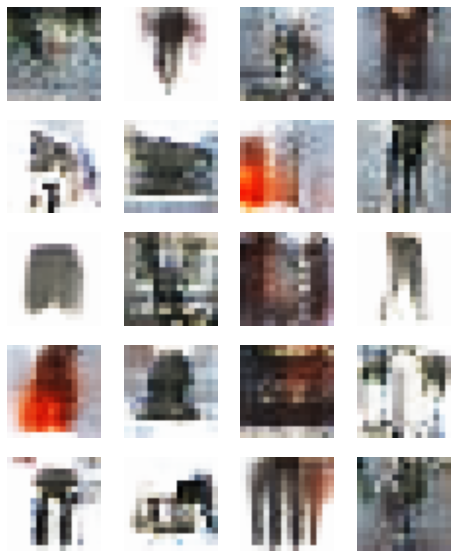

Batch: 1525 / 62500
Alpha: 0.08133333333333333
D Loss: R: -18.906233 F: -24.637674 GP: 18.521748
G Loss: 9.656275
Batch: 1550 / 62500
Alpha: 0.08266666666666667
D Loss: R: -23.008169 F: -20.561995 GP: 13.940873
G Loss: 11.059927
Batch: 1575 / 62500
Alpha: 0.084
D Loss: R: 23.382612 F: -63.035698 GP: 2.204195
G Loss: 168.048477
Batch: 1600 / 62500
Alpha: 0.08533333333333333
D Loss: R: -21.537176 F: -12.708424 GP: 3.489205
G Loss: 8.745640
Batch: 1625 / 62500
Alpha: 0.08666666666666667
D Loss: R: -18.331717 F: -24.221695 GP: 7.891462
G Loss: 16.710705
Batch: 1650 / 62500
Alpha: 0.088
D Loss: R: -45.861847 F: -5.286635 GP: 22.831844
G Loss: 17.414604
Batch: 1675 / 62500
Alpha: 0.08933333333333333
D Loss: R: 1.083690 F: -42.058777 GP: 10.046919
G Loss: 15.105953
Batch: 1700 / 62500
Alpha: 0.09066666666666667
D Loss: R: -47.175182 F: 15.048913 GP: 23.602673
G Loss: 22.600140
Batch: 1725 / 62500
Alpha: 0.092
D Loss: R: -8.289284 F: -44.216621 GP: 9.771470
G Loss: 2.688289
Batch: 1750 / 62500

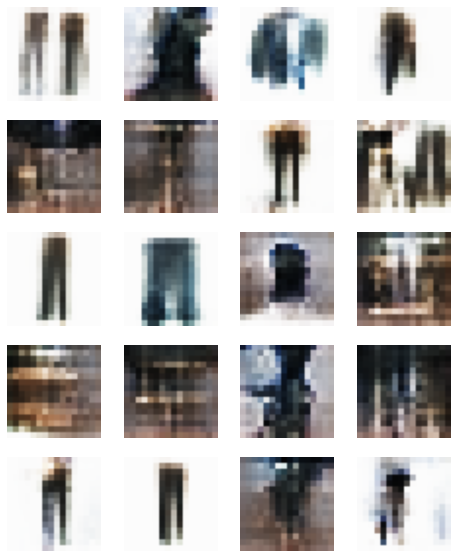

Batch: 2025 / 62500
Alpha: 0.108
D Loss: R: 5.524901 F: -55.661209 GP: 6.545105
G Loss: 49.700272
Batch: 2050 / 62500
Alpha: 0.10933333333333334
D Loss: R: -13.516531 F: -17.087975 GP: 4.630527
G Loss: 28.019958
Batch: 2075 / 62500
Alpha: 0.11066666666666666
D Loss: R: -35.440254 F: -30.041662 GP: 37.897514
G Loss: 42.287361
Batch: 2100 / 62500
Alpha: 0.112
D Loss: R: -35.350174 F: -11.702078 GP: 5.775020
G Loss: 21.444603
Batch: 2125 / 62500
Alpha: 0.11333333333333333
D Loss: R: -12.287407 F: -50.208660 GP: 36.089043
G Loss: 18.176033
Batch: 2150 / 62500
Alpha: 0.11466666666666667
D Loss: R: 64.286850 F: -100.397469 GP: 4.532678
G Loss: 113.424088
Batch: 2175 / 62500
Alpha: 0.116
D Loss: R: -39.769985 F: -10.504835 GP: 20.358801
G Loss: 17.168232
Batch: 2200 / 62500
Alpha: 0.11733333333333333
D Loss: R: 31.344263 F: -53.221329 GP: 1.903472
G Loss: 88.785446
Batch: 2225 / 62500
Alpha: 0.11866666666666667
D Loss: R: 25.437584 F: -62.807564 GP: 7.644109
G Loss: 43.191566
Batch: 2250 / 62

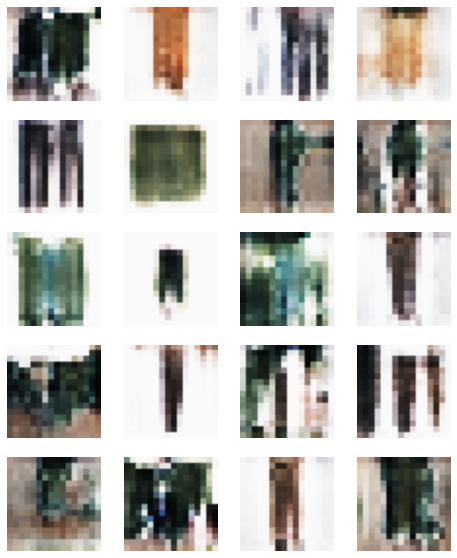

KeyboardInterrupt: ignored

In [ ]:
train_progan(gan, 32,
             checkpoint_path=base_dir+'32x32/',
             transition_kimg=600,
             total_kimg=2000)

In [ ]:
gan.load(32, base_dir+'32x32/')
K.set_value(gan.alpha_G, 1.0)
plot_generated_images(gan, 32, latents_in=latents_test)

In [ ]:
plot_real_images(64)

In [ ]:
gan = ProGAN(batch_size=16)

In [ ]:
gan.load(32, base_dir+'32x32/')
gan.transfer_previous_resolution_weights(64)

In [ ]:
train_progan(gan, 64,
             checkpoint_path=base_dir+'64x64/',
             transition_kimg=600,
             total_kimg=2000)

In [ ]:
gan.load(64, base_dir+'64x64/', True)

In [ ]:
gan.load(64, base_dir+'64x64/')
K.set_value(gan.alpha_G, 1.0)
plot_generated_images(gan, 64, latents_in=latents_test)

In [ ]:
plot_real_images(128)

In [ ]:
gan = ProGAN(batch_size=8, learning_rate=1e-4)

In [ ]:
gan.load(64, base_dir+'64x64/')
gan.transfer_previous_resolution_weights(128)

In [ ]:

train_progan(gan, 128,
             checkpoint_path=base_dir+'128x128/',
             transition_kimg=600,
             total_kimg=4000)

In [ ]:
gan.load(128, base_dir+'128x128/', True)

In [ ]:
gan.load(128, base_dir+'128x128/')
K.set_value(gan.alpha_G, 1.0)
plot_generated_images(gan, 128, latents_in=latents_test)

In [ ]:
gan = ProGAN(batch_size=32)

In [ ]:
gan.load(128, base_dir+'128x128-resume7/')
K.set_value(gan.alpha_G, 1.0)
plot_generated_images(gan, 128)

In [ ]:
def plot_discriminators_choice(gan, resolution,
                               batch_size=32,
                               n_to_show=20,
                               n_rows=5,
                               use_best=True):
  resolution_log2 = int(np.log2(resolution))

  X_samples = []
  for _ in range(n_to_show):
    latents_in = np.random.normal(size=(batch_size, gan.latent_size))
    label = resolution_label(resolution_log2)
    X_batch = gan.G[label].predict(latents_in)
    scores = gan.D[label].predict(X_batch)
    idx = np.argmin(scores) if use_best else np.argmax(scores)
    if resolution > 4:
      X_batch = X_batch[0]
    X_samples.append(X_batch[idx]) 
  
  fig = plt.figure(figsize=(8, 10))
  fig.tight_layout()
  fig.subplots_adjust(hspace=0.0, wspace=0.0)

  for i, x in enumerate(X_samples):
    ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
    ax.axis('off')
    ax.imshow(np.clip(np.array(x).squeeze(), 0.0, 1.0),
              interpolation='antialiased')

In [ ]:
plot_discriminators_choice(gan, 128)

In [ ]:
plot_discriminators_choice(gan, 128, use_best=False)

In [ ]:
from IPython.display import clear_output

def plot_human_selected_images(gan,
                               resolution,
                               batch_size=8,
                               n_to_show=20,
                               n_rows=5):
  """Generate a human-led sequence of text."""
  resolution_log2 = int(np.log2(resolution))
  X_samples = []
  i = 0
  while i < n_to_show:
    latents_in = np.random.normal(size=(batch_size, gan.latent_size))
    label = resolution_label(resolution_log2)
    X_batch = gan.G[label].predict(latents_in)
    if resolution > 4:
      X_batch = X_batch[0]

    fig = plt.figure(figsize=(5 * batch_size // 4, 5 * 4))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    for j, x in enumerate(X_batch):
      ax = fig.add_subplot(batch_size, batch_size // 4, j + 1)
      ax.axis('off')
      ax.imshow(np.clip(np.array(x).squeeze(), 0.0, 1.0),
                interpolation='antialiased')
    plt.show()

    try:
      idx = int(input())
      X_samples.append(X_batch[idx])
      i += 1
    except ValueError:
      pass

    clear_output()

  fig = plt.figure(figsize=(8, 10))
  fig.tight_layout()
  fig.subplots_adjust(hspace=0.0, wspace=0.0)

  for i, x in enumerate(X_samples):
    ax = fig.add_subplot(n_rows, n_to_show // n_rows, i + 1)
    ax.axis('off')
    ax.imshow(np.clip(np.array(x).squeeze(), 0.0, 1.0),
              interpolation='antialiased')

In [ ]:
gan = ProGAN(batch_size=8)

In [ ]:
gan.load(128, base_dir+'128x128-resume7/')
K.set_value(gan.alpha_G, 1.0)

In [ ]:
plot_human_selected_images(gan, 128)